Import & StatType Class Definition

In [170]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from enum import Enum
import scipy.stats
import matplotlib.cm as cm
from omnetpp.scave import results, chart, utils

class StatType(Enum):
    SCALAR = "count"
    VECTOR = "vector"

Script Parameters

In [171]:
mpl.rcParams['figure.dpi'] = 300
relPath = "../results/"

DEBUG = True

isDos = False
simName = "MMS_MITM_Wired"

rep = 20
simTimeLimit = 120
numClients = 1
numServers = 2

In [172]:
fileNamesSca = []
fileNamesVec = []

cliMeasNames = [("readResponseReceivedTime", StatType.VECTOR), ("commandResponseReceivedTime", StatType.VECTOR), ("measureReceivedAmount", StatType.VECTOR), ("readSent", StatType.SCALAR), ("commandSent", StatType.SCALAR), ("readResponse", StatType.SCALAR), 
             ("commandResponse", StatType.SCALAR), ("readResponseTimeout", StatType.SCALAR), ("commandResponseTimeout", StatType.SCALAR)]
evilMeasNames = [("measureBlock", StatType.SCALAR), ("measureCompromised", StatType.SCALAR), ("readRequestBlock", StatType.SCALAR), ("readRequestCompromised", StatType.SCALAR), 
                 ("commandRequestBlock", StatType.SCALAR), ("commandRequestCompromised", StatType.SCALAR), ("readResponseBlock", StatType.SCALAR), ("readResponseCompromised", StatType.SCALAR),
                 ("commandResponseBlock", StatType.SCALAR), ("commandResponseCompromised", StatType.SCALAR)]

for i in range(0,rep):
    fileNamesSca.append(relPath + simName + '-#' + i.__str__() + '.sca')
    fileNamesVec.append(relPath + simName + '-#' + i.__str__() + '.vec')
    

if DEBUG:
    print(fileNamesSca)
    print(fileNamesVec)


['../results/MMS_MITM_Wired-#0.sca', '../results/MMS_MITM_Wired-#1.sca', '../results/MMS_MITM_Wired-#2.sca', '../results/MMS_MITM_Wired-#3.sca', '../results/MMS_MITM_Wired-#4.sca', '../results/MMS_MITM_Wired-#5.sca', '../results/MMS_MITM_Wired-#6.sca', '../results/MMS_MITM_Wired-#7.sca', '../results/MMS_MITM_Wired-#8.sca', '../results/MMS_MITM_Wired-#9.sca', '../results/MMS_MITM_Wired-#10.sca', '../results/MMS_MITM_Wired-#11.sca', '../results/MMS_MITM_Wired-#12.sca', '../results/MMS_MITM_Wired-#13.sca', '../results/MMS_MITM_Wired-#14.sca', '../results/MMS_MITM_Wired-#15.sca', '../results/MMS_MITM_Wired-#16.sca', '../results/MMS_MITM_Wired-#17.sca', '../results/MMS_MITM_Wired-#18.sca', '../results/MMS_MITM_Wired-#19.sca']
['../results/MMS_MITM_Wired-#0.vec', '../results/MMS_MITM_Wired-#1.vec', '../results/MMS_MITM_Wired-#2.vec', '../results/MMS_MITM_Wired-#3.vec', '../results/MMS_MITM_Wired-#4.vec', '../results/MMS_MITM_Wired-#5.vec', '../results/MMS_MITM_Wired-#6.vec', '../results/MMS_

Function to create the statistics filter

In [173]:
def createFilter(measNames):
    filter = ""##"type =~ \"scalar\" AND ("
    for i in range(len(measNames)):
        if i != len(measNames)-1:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\" OR "
        else:
            filter += "name =~ \"*" + measNames[i][0] + ":" + measNames[i][1].value + "\""##)"
    return filter

In [174]:
dataSca = results.read_result_files(fileNamesSca, filter_expression=createFilter(cliMeasNames + evilMeasNames))
dataVec = results.read_result_files(fileNamesVec, filter_expression=createFilter(cliMeasNames + evilMeasNames))
vec = results.get_vectors(dataVec)
scl = results.get_scalars(dataSca)

if DEBUG:
    print(createFilter(cliMeasNames + evilMeasNames))
    scl.to_csv("./outSC.csv", mode="w", header=True)
    vec.to_csv("./outVC.csv", mode="w", header=True)

name =~ "*readResponseReceivedTime:vector" OR name =~ "*commandResponseReceivedTime:vector" OR name =~ "*measureReceivedAmount:vector" OR name =~ "*readSent:count" OR name =~ "*commandSent:count" OR name =~ "*readResponse:count" OR name =~ "*commandResponse:count" OR name =~ "*readResponseTimeout:count" OR name =~ "*commandResponseTimeout:count" OR name =~ "*measureBlock:count" OR name =~ "*measureCompromised:count" OR name =~ "*readRequestBlock:count" OR name =~ "*readRequestCompromised:count" OR name =~ "*commandRequestBlock:count" OR name =~ "*commandRequestCompromised:count" OR name =~ "*readResponseBlock:count" OR name =~ "*readResponseCompromised:count" OR name =~ "*commandResponseBlock:count" OR name =~ "*commandResponseCompromised:count"


Plot client measures for each client aggregating all the repetitions 

In [175]:
def plotBoxWiskerSca(measNames, numClients, numServers, title = "", cli = "client"):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(17*numClients)
    fig.set_figwidth(22)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            box = pd.DataFrame()
            for meas in measNames:
                strElem = ""
                if cli == "evilClient":
                    strElem = cli + ".app[" + str(j) + "]"
                else:
                    strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
                
                if meas[1] == StatType.SCALAR:
                    flt = scl[scl["name"].str.contains(meas[0] + ":" + meas[1].value)]
                    flt = flt[flt["module"].str.endswith(strElem)]
                    box[meas[0]] = flt["value"].reset_index(drop=True)
                 
            box = box.replace(np.nan, 0)
            outVec.append(box)
            if DEBUG:
                box.to_csv("./out.csv", mode="w", header=True)
            if numClients != 1: 
                box.boxplot(ax=axes[i][j], grid=False, rot=90)
                axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                box.boxplot(ax=axes[j], grid=False, rot=90)
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')
    return outVec

In [176]:
def plotBoxWiskerVec(numClients, numServers, title = "", cli = "client", vecMeasName = "measureReceivedAmount", numRanges = 0):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(12*numClients)
    fig.set_figwidth(25)
    
    ranges = list()
    if numRanges != 0:
        incr = simTimeLimit/numRanges
        nxt = 0
        while nxt+incr <= 120:
            ranges.append((nxt, nxt + incr))
            nxt += incr
    if DEBUG:
        print(ranges)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            if numRanges == 0:   
                box = None
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    if box is None:
                        box = pd.DataFrame(columns=vecTime)
                    box.loc[rowNum] = vecValue.tolist()
                    rowNum += 1   
                                    
                box = box.replace(np.nan, 0)
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                box.boxplot(ax=axes[j], grid=False, rot=90)
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                box = pd.DataFrame(columns=["value", "ranges"])
                rowNum = 0
                for row in flt.itertuples():
                    vecValue = pd.Series(row.vecvalue)
                    vecTime = pd.Series(row.vectime)
                    for val, time in zip(vecValue, vecTime):    
                        for rang in ranges:
                            if time > rang[0] and time <= rang[1]:
                                box.loc[rowNum] = list((val, rang))
                                rowNum += 1
                                break   
                                    
                outVec.append(box)
                if DEBUG:
                    box.to_csv("./out.csv", mode="w", header=True)
                if numClients != 1:
                    box.boxplot(ax=axes[i][j], column="value", by="ranges", grid=False, rot=90)
                    axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
                else:
                    box.boxplot(ax=axes[j], column="value", by="ranges", grid=False, rot=90)
                    axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')                    
    return outVec

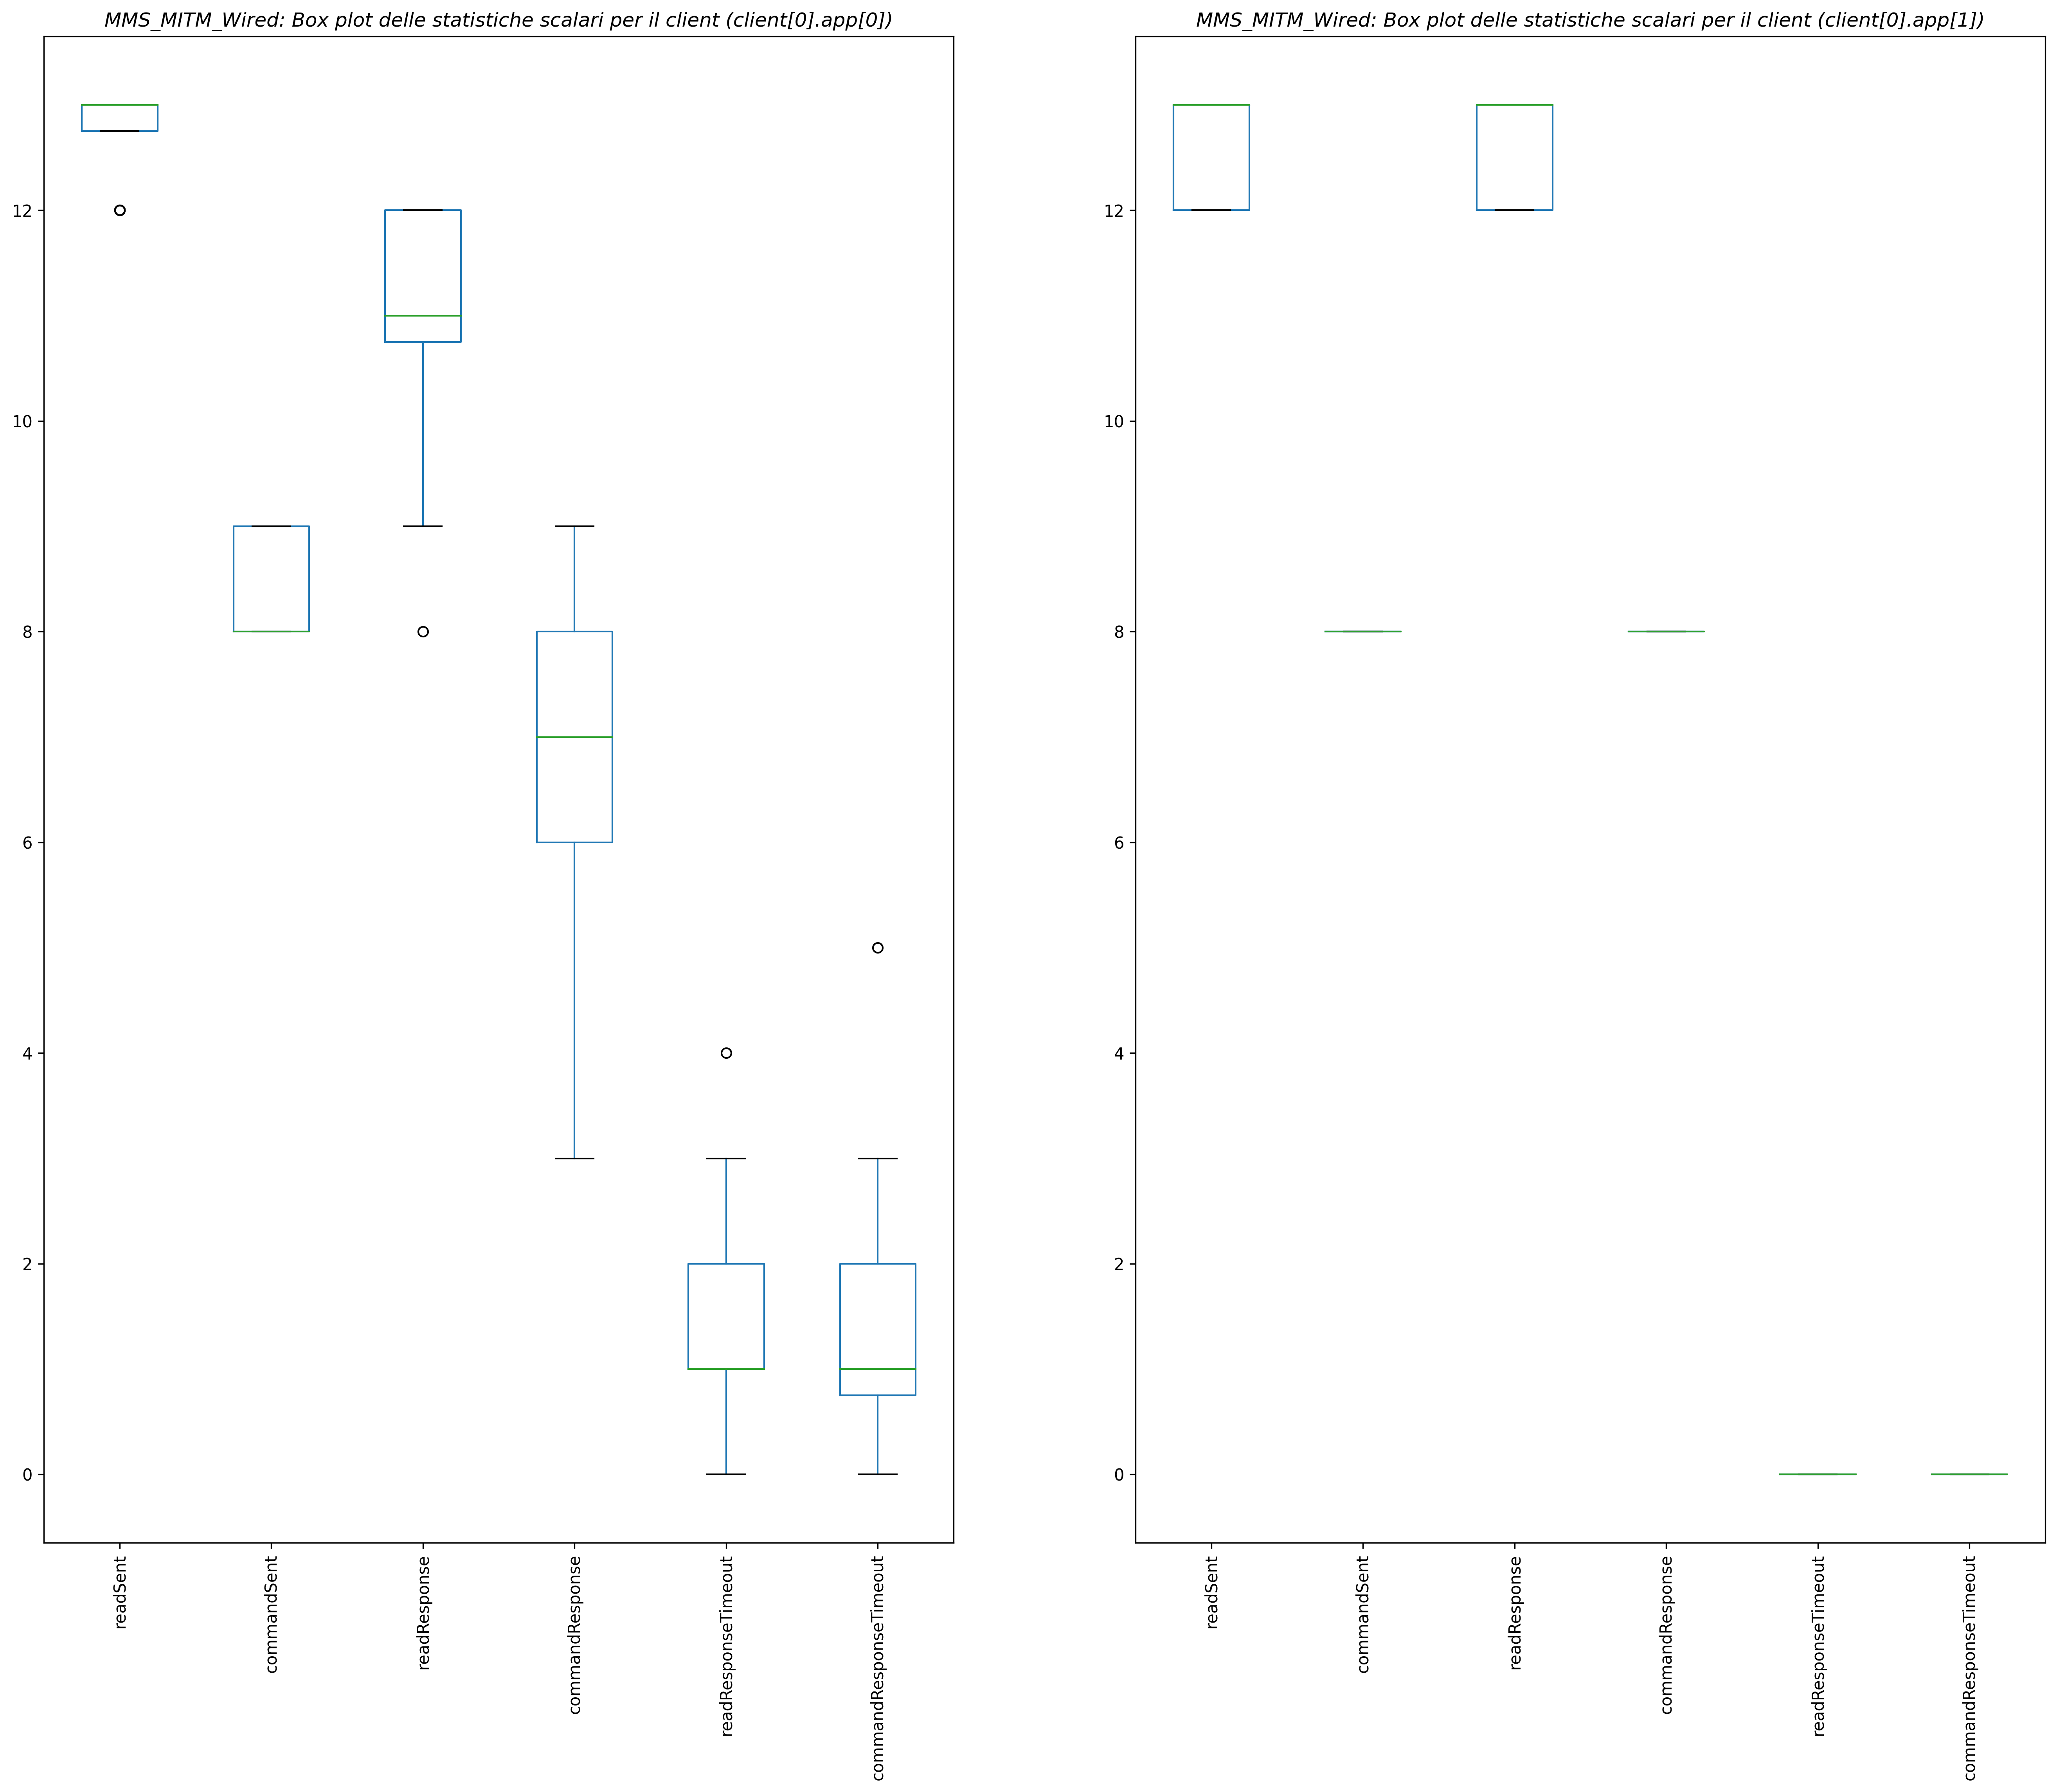

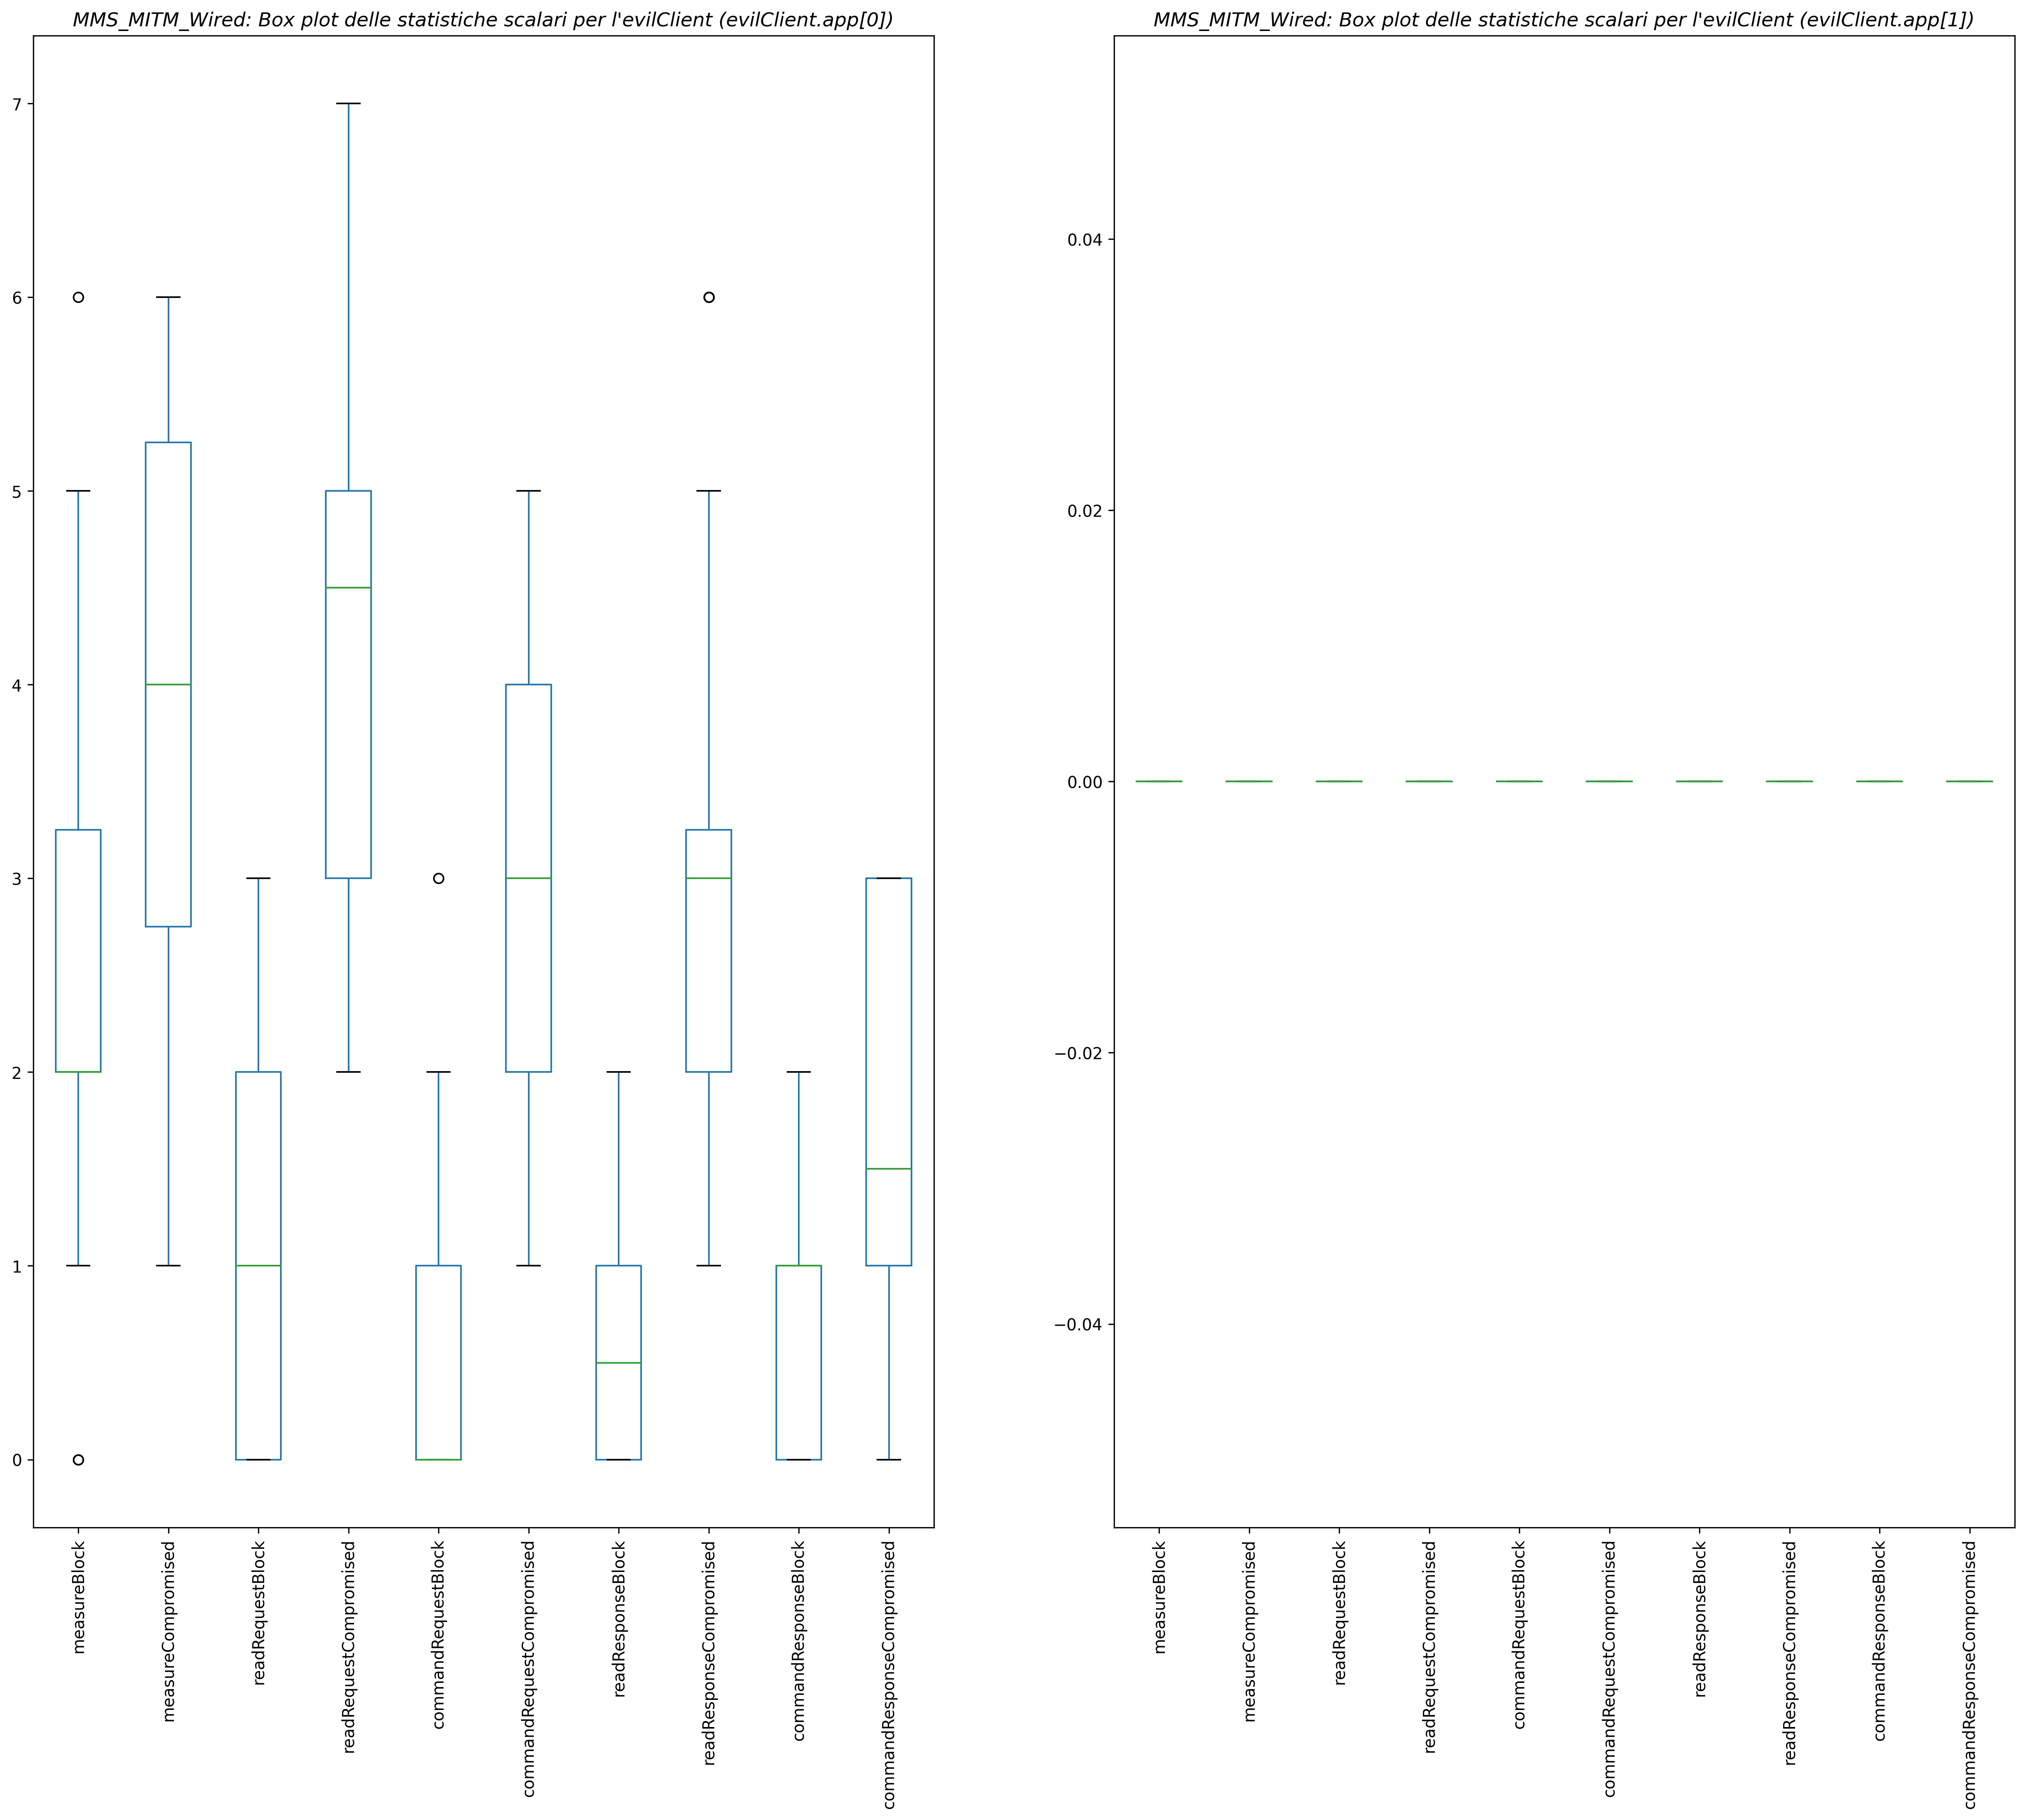

In [177]:
cliScaDfList = plotBoxWiskerSca(cliMeasNames, numClients, numServers, title=simName + ": Box plot delle statistiche scalari per il client")
evilScaDfList = plotBoxWiskerSca(evilMeasNames, 1, numServers, cli="evilClient", title=simName + ": Box plot delle statistiche scalari per l'evilClient")

Scatter Matrices for clients

## Data description for client[0].app[0] ##
        readSent  commandSent  readResponse  commandResponse  \
count  20.000000    20.000000     20.000000        20.000000   
mean   12.750000     8.300000     11.000000         6.900000   
std     0.444262     0.470162      1.123903         1.333772   
min    12.000000     8.000000      8.000000         3.000000   
25%    12.750000     8.000000     10.750000         6.000000   
50%    13.000000     8.000000     11.000000         7.000000   
75%    13.000000     9.000000     12.000000         8.000000   
max    13.000000     9.000000     12.000000         9.000000   

       readResponseTimeout  commandResponseTimeout  
count            20.000000               20.000000  
mean              1.400000                1.250000  
std               1.046297                1.208522  
min               0.000000                0.000000  
25%               1.000000                0.750000  
50%               1.000000                1.000000  
75%     

/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 8.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 8.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 8.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/

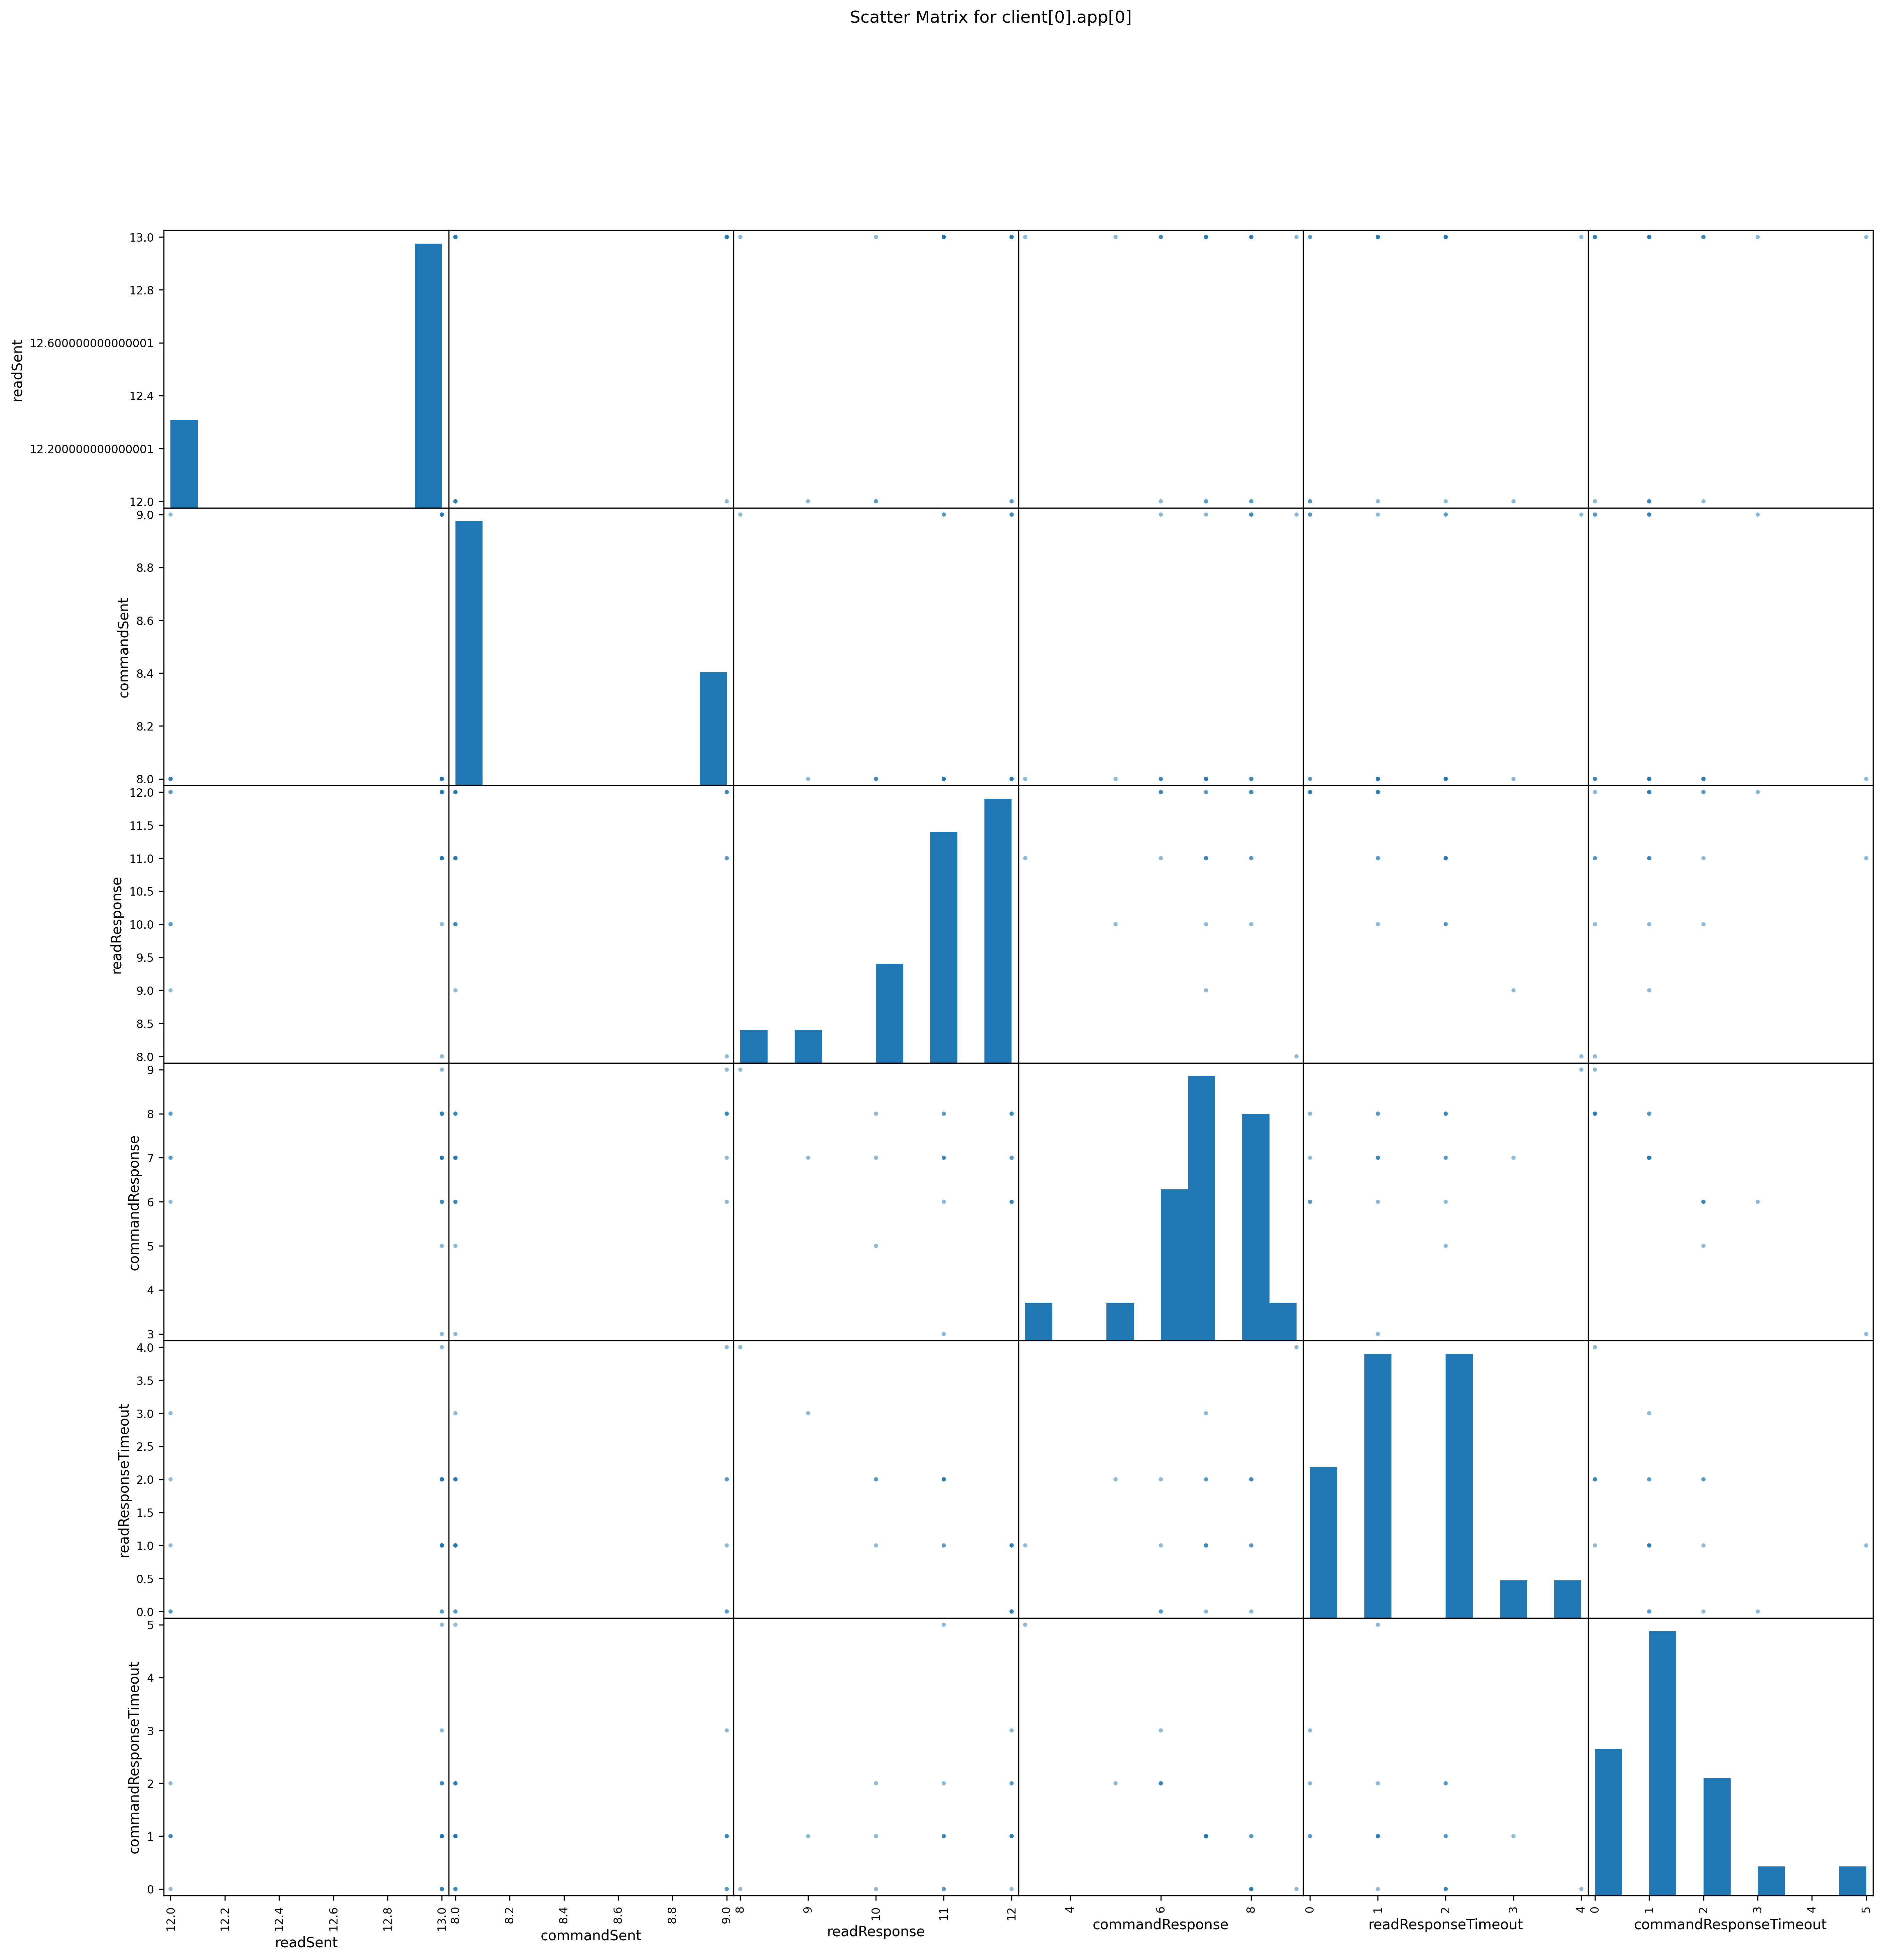

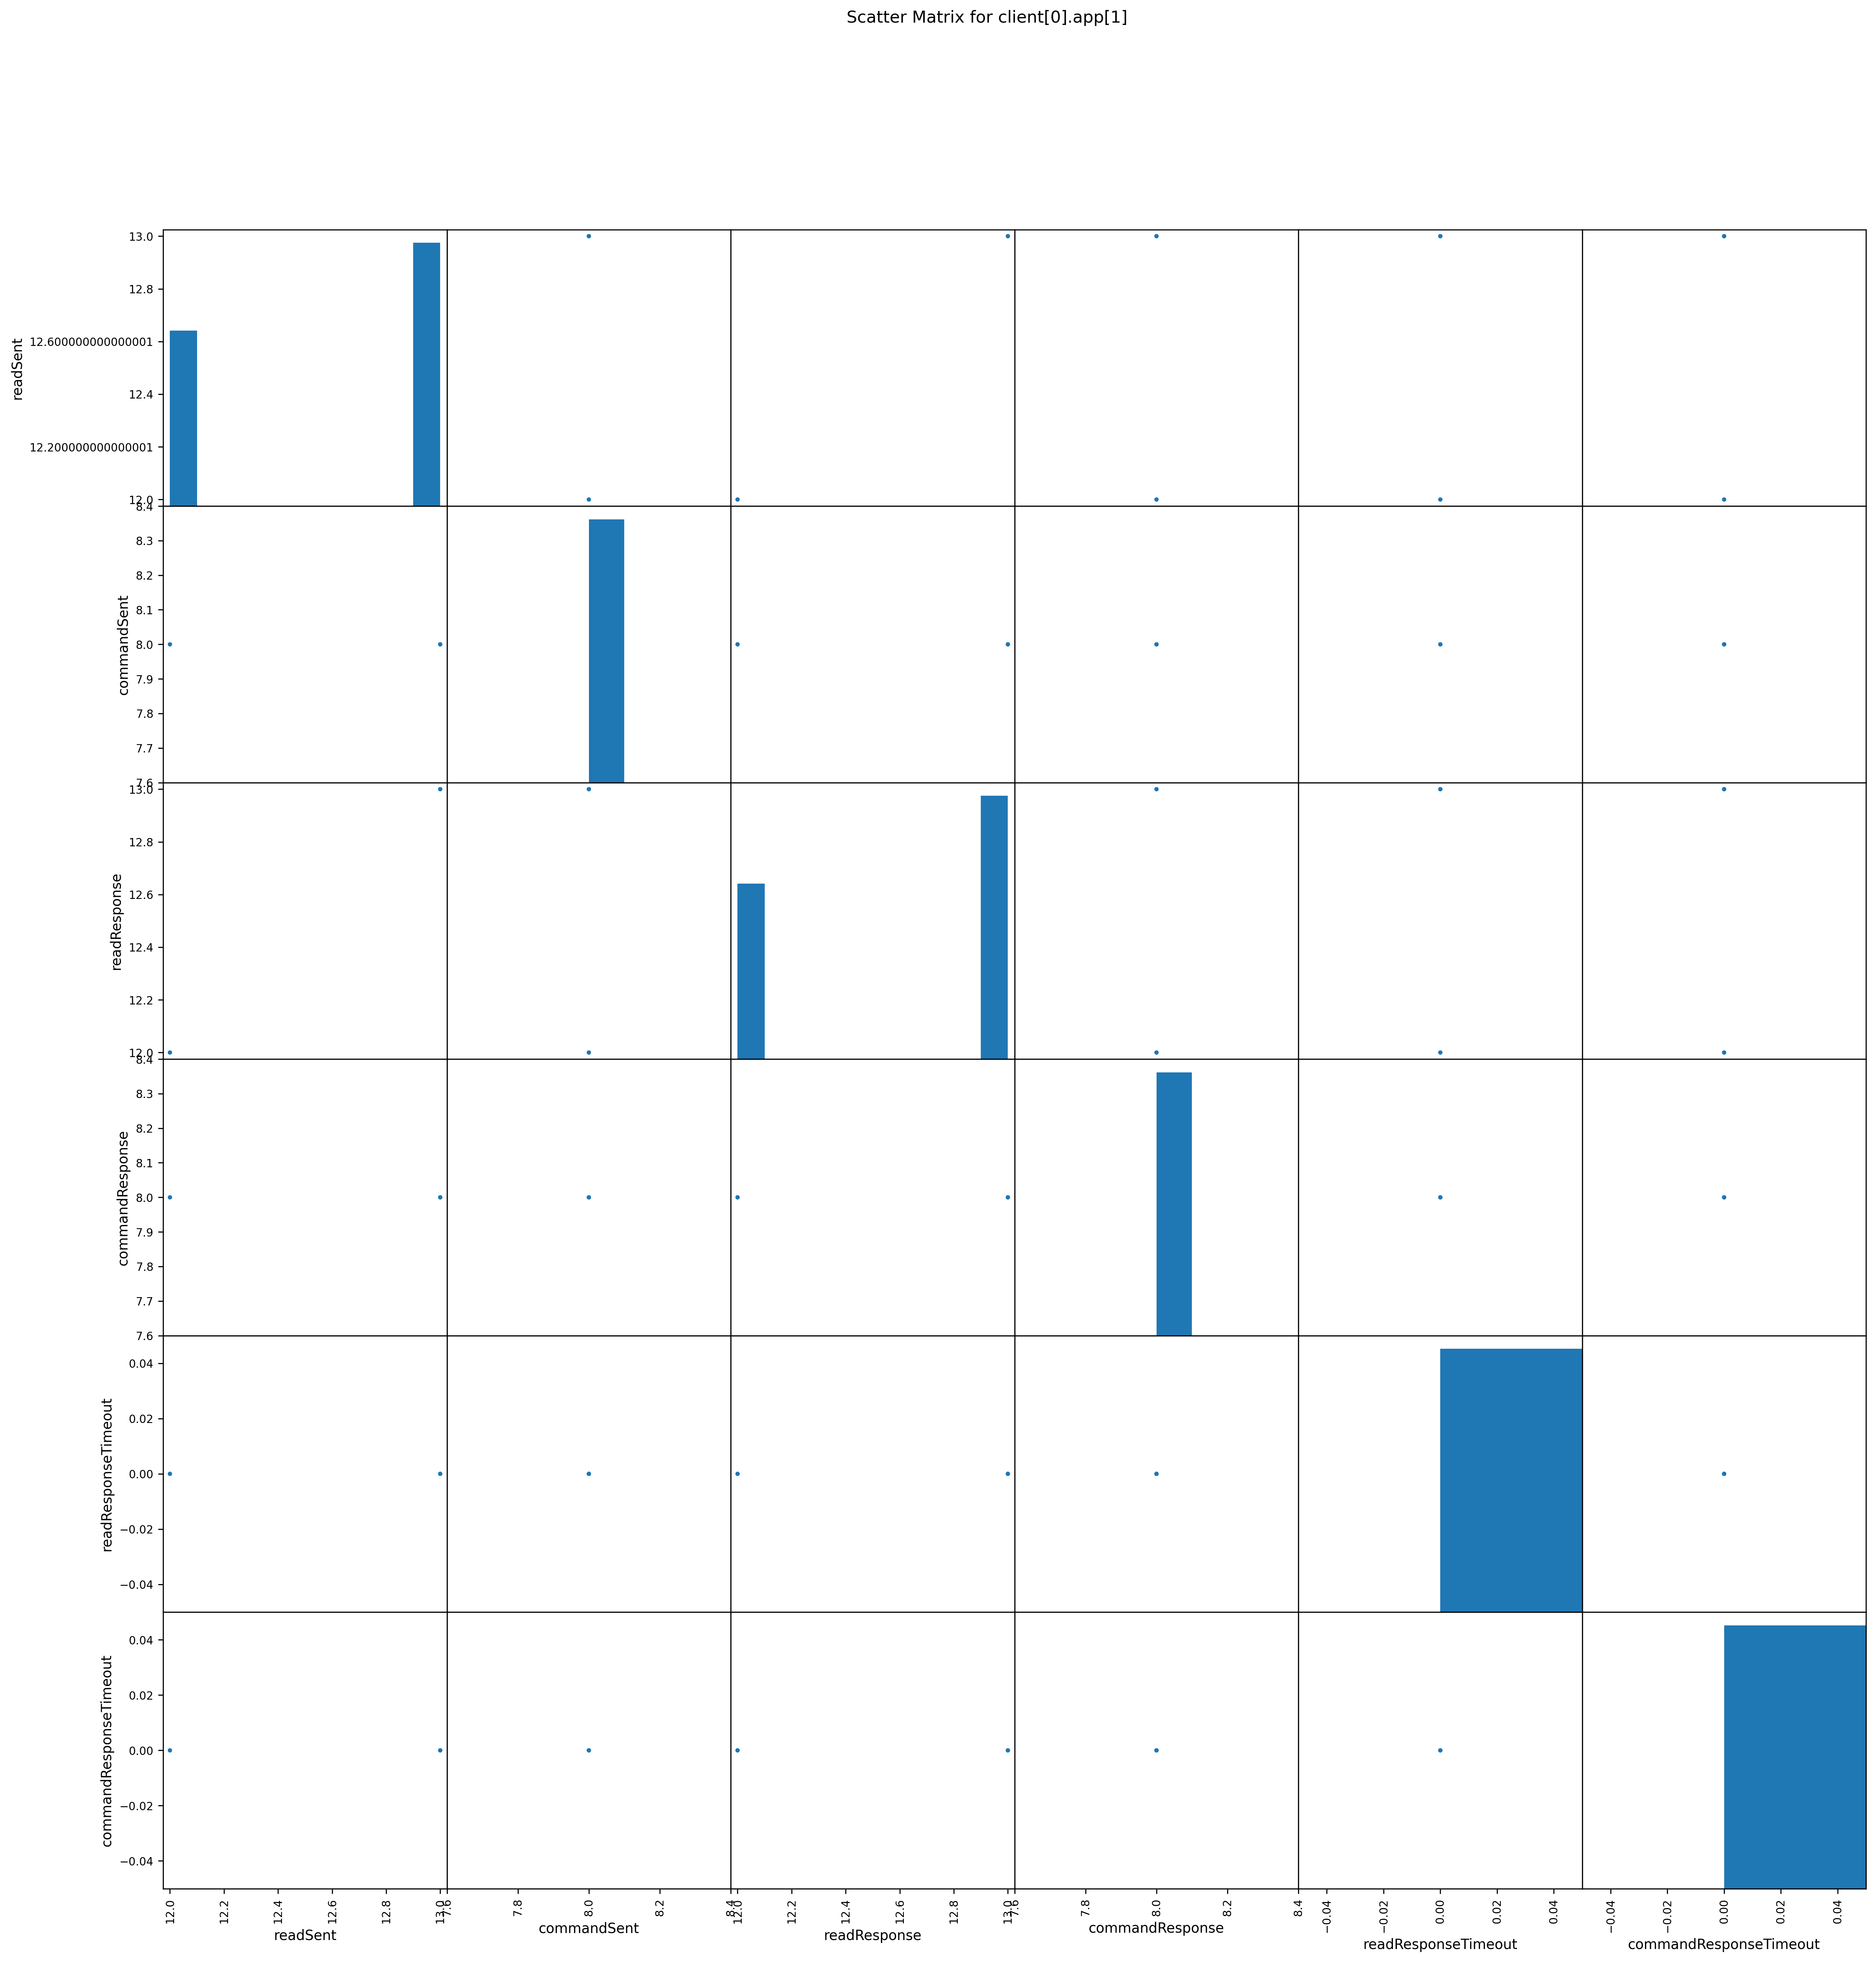

In [178]:
for i in range(numClients):
    for j in range(numServers):
        df = cliScaDfList[(i+1)*j]
        print("## Data description for client[" + str(i) + "].app[" + str(j) + "] ##")
        print(df.describe())
        print("## Correlation Matrix ##")
        print(df.corr())
        pd.plotting.scatter_matrix(df, figsize=(22,22))
        plt.suptitle("Scatter Matrix for client[" + str(i) + "].app[" + str(j) + "]")


Scatter matrix for the evilClient

## Data description for evilClient.app[0] ##
       measureBlock  measureCompromised  readRequestBlock  \
count     20.000000           20.000000         20.000000   
mean       2.600000            4.050000          1.050000   
std        1.602629            1.700619          0.887041   
min        0.000000            1.000000          0.000000   
25%        2.000000            2.750000          0.000000   
50%        2.000000            4.000000          1.000000   
75%        3.250000            5.250000          2.000000   
max        6.000000            6.000000          3.000000   

       readRequestCompromised  commandRequestBlock  commandRequestCompromised  \
count               20.000000            20.000000                  20.000000   
mean                 4.350000             0.600000                   3.050000   
std                  1.386969             0.820783                   1.050063   
min                  2.000000             0.000000                   1.000000   


/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/dosclic98/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:115: RuntimeWarning: invalid value encountered in divide
  adj = (locs - lim1[0]) / (lim1[1] - lim1[0])


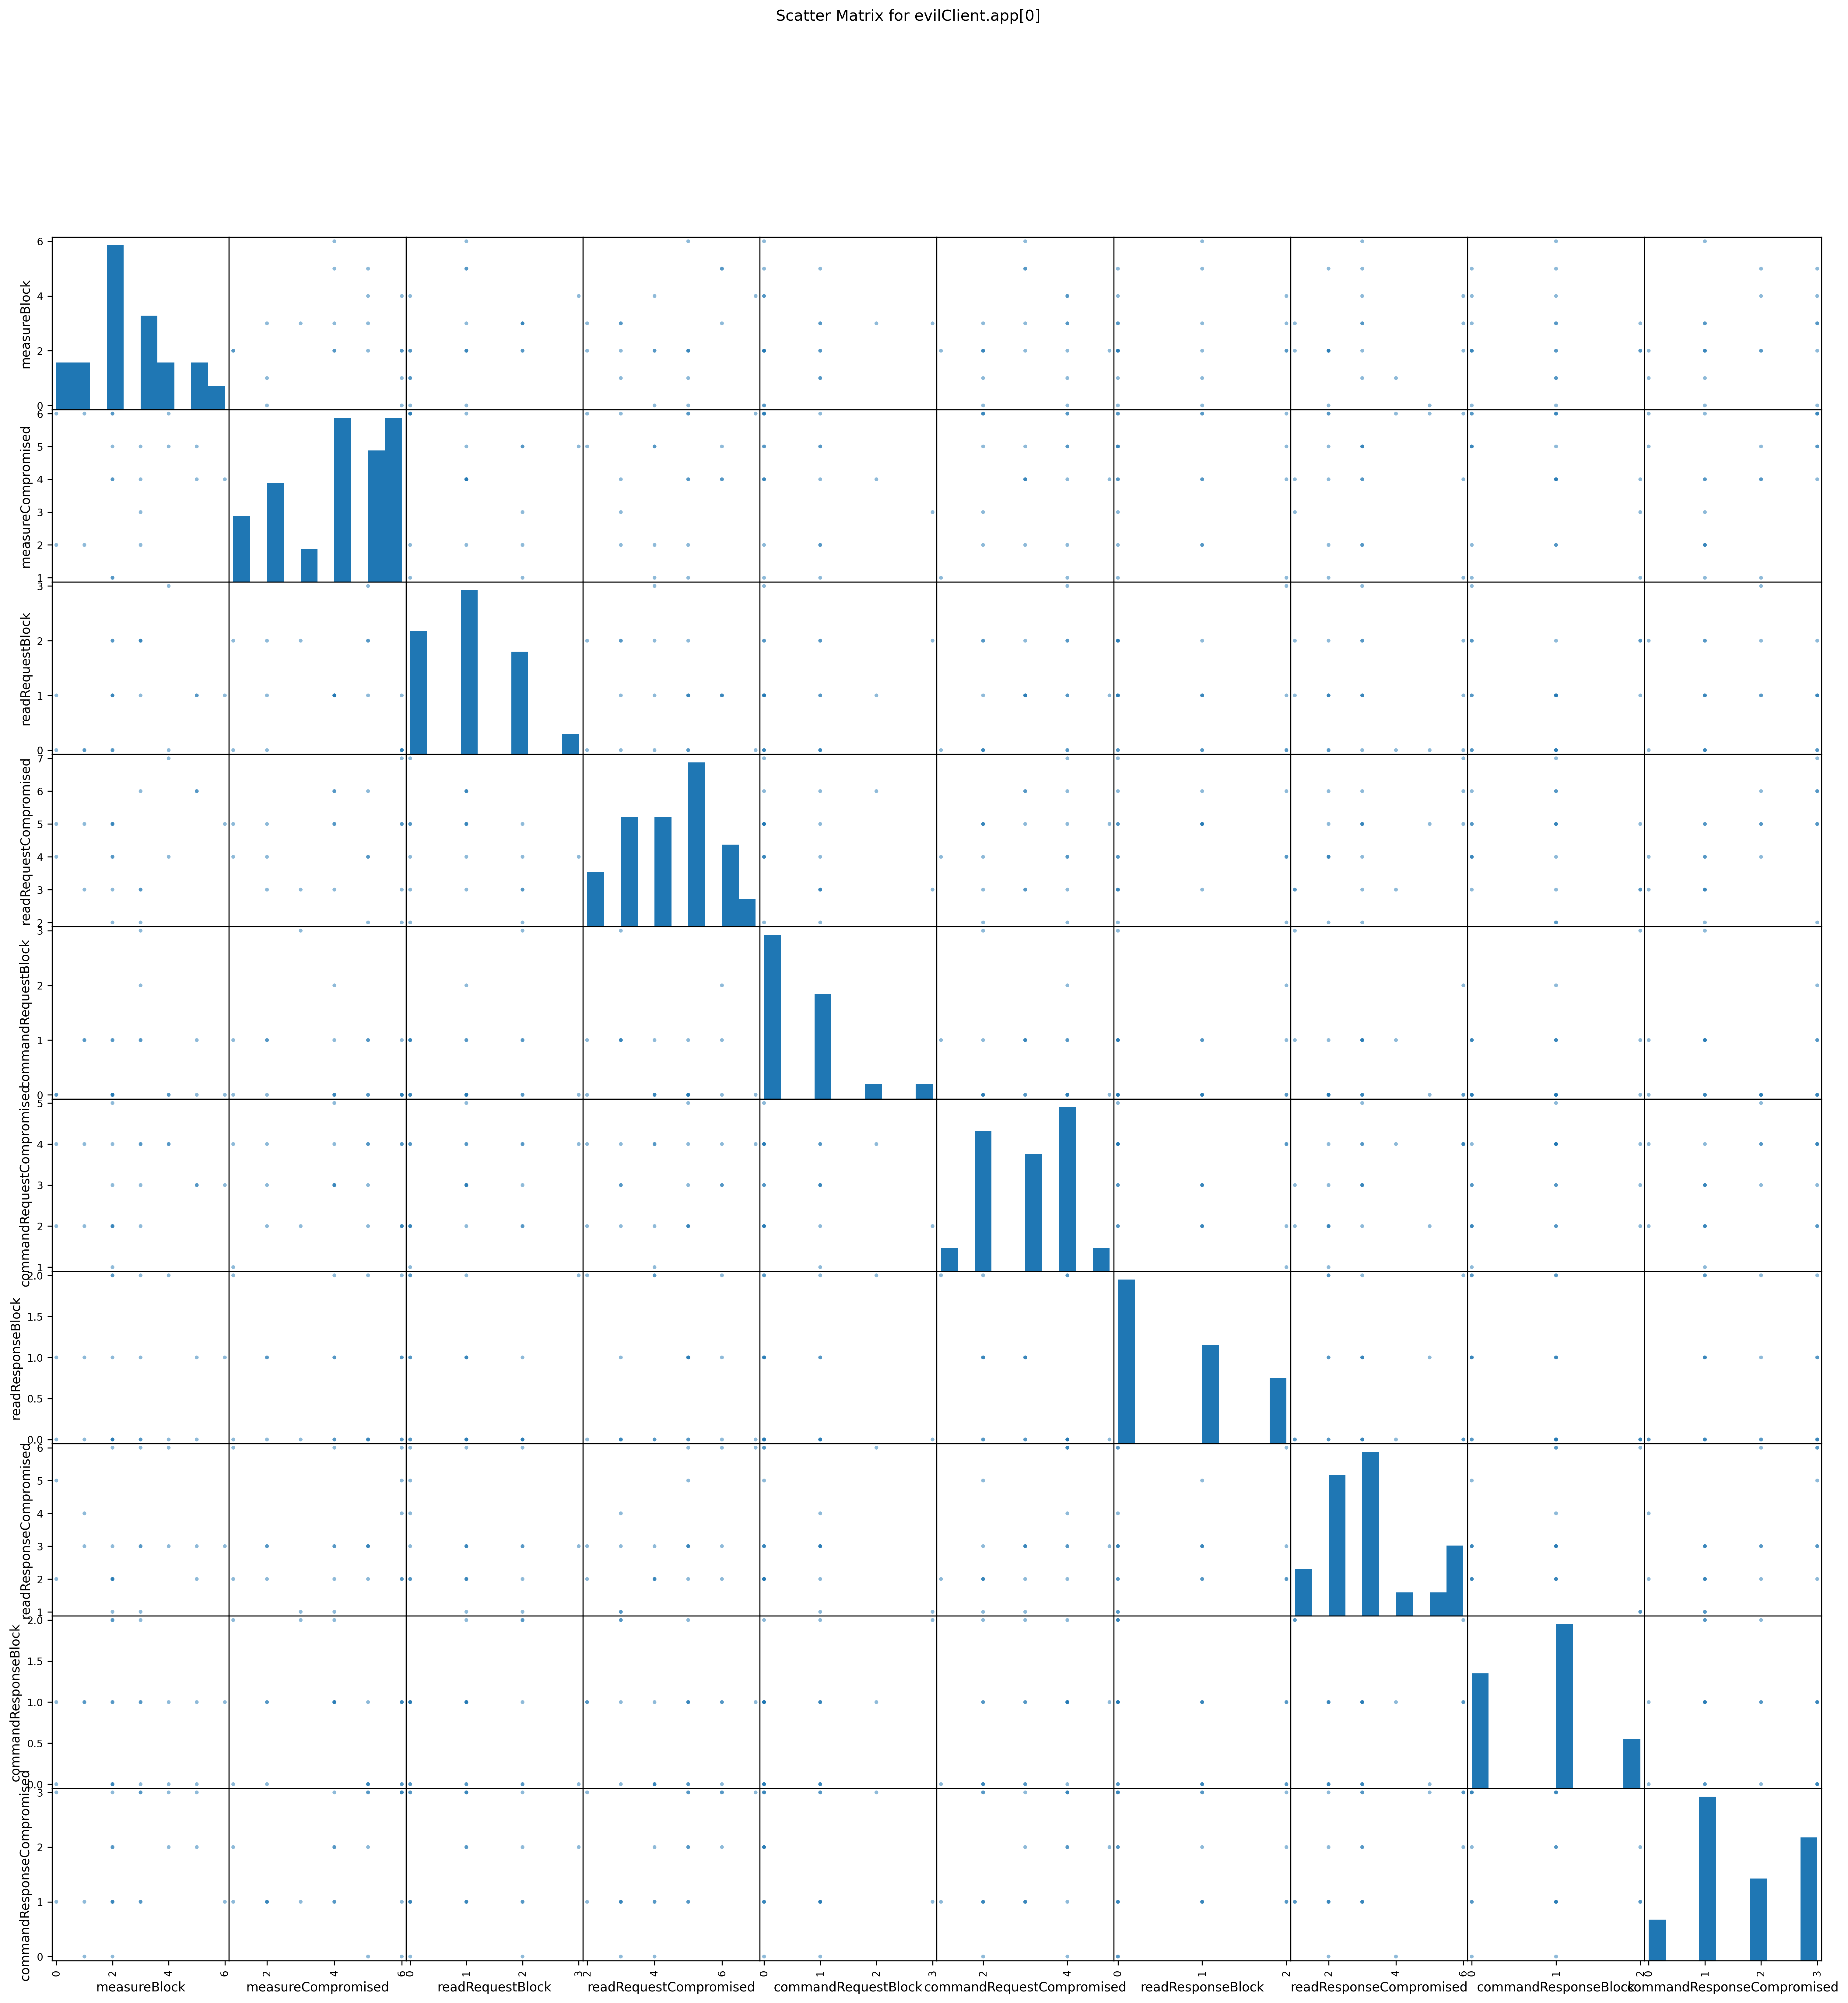

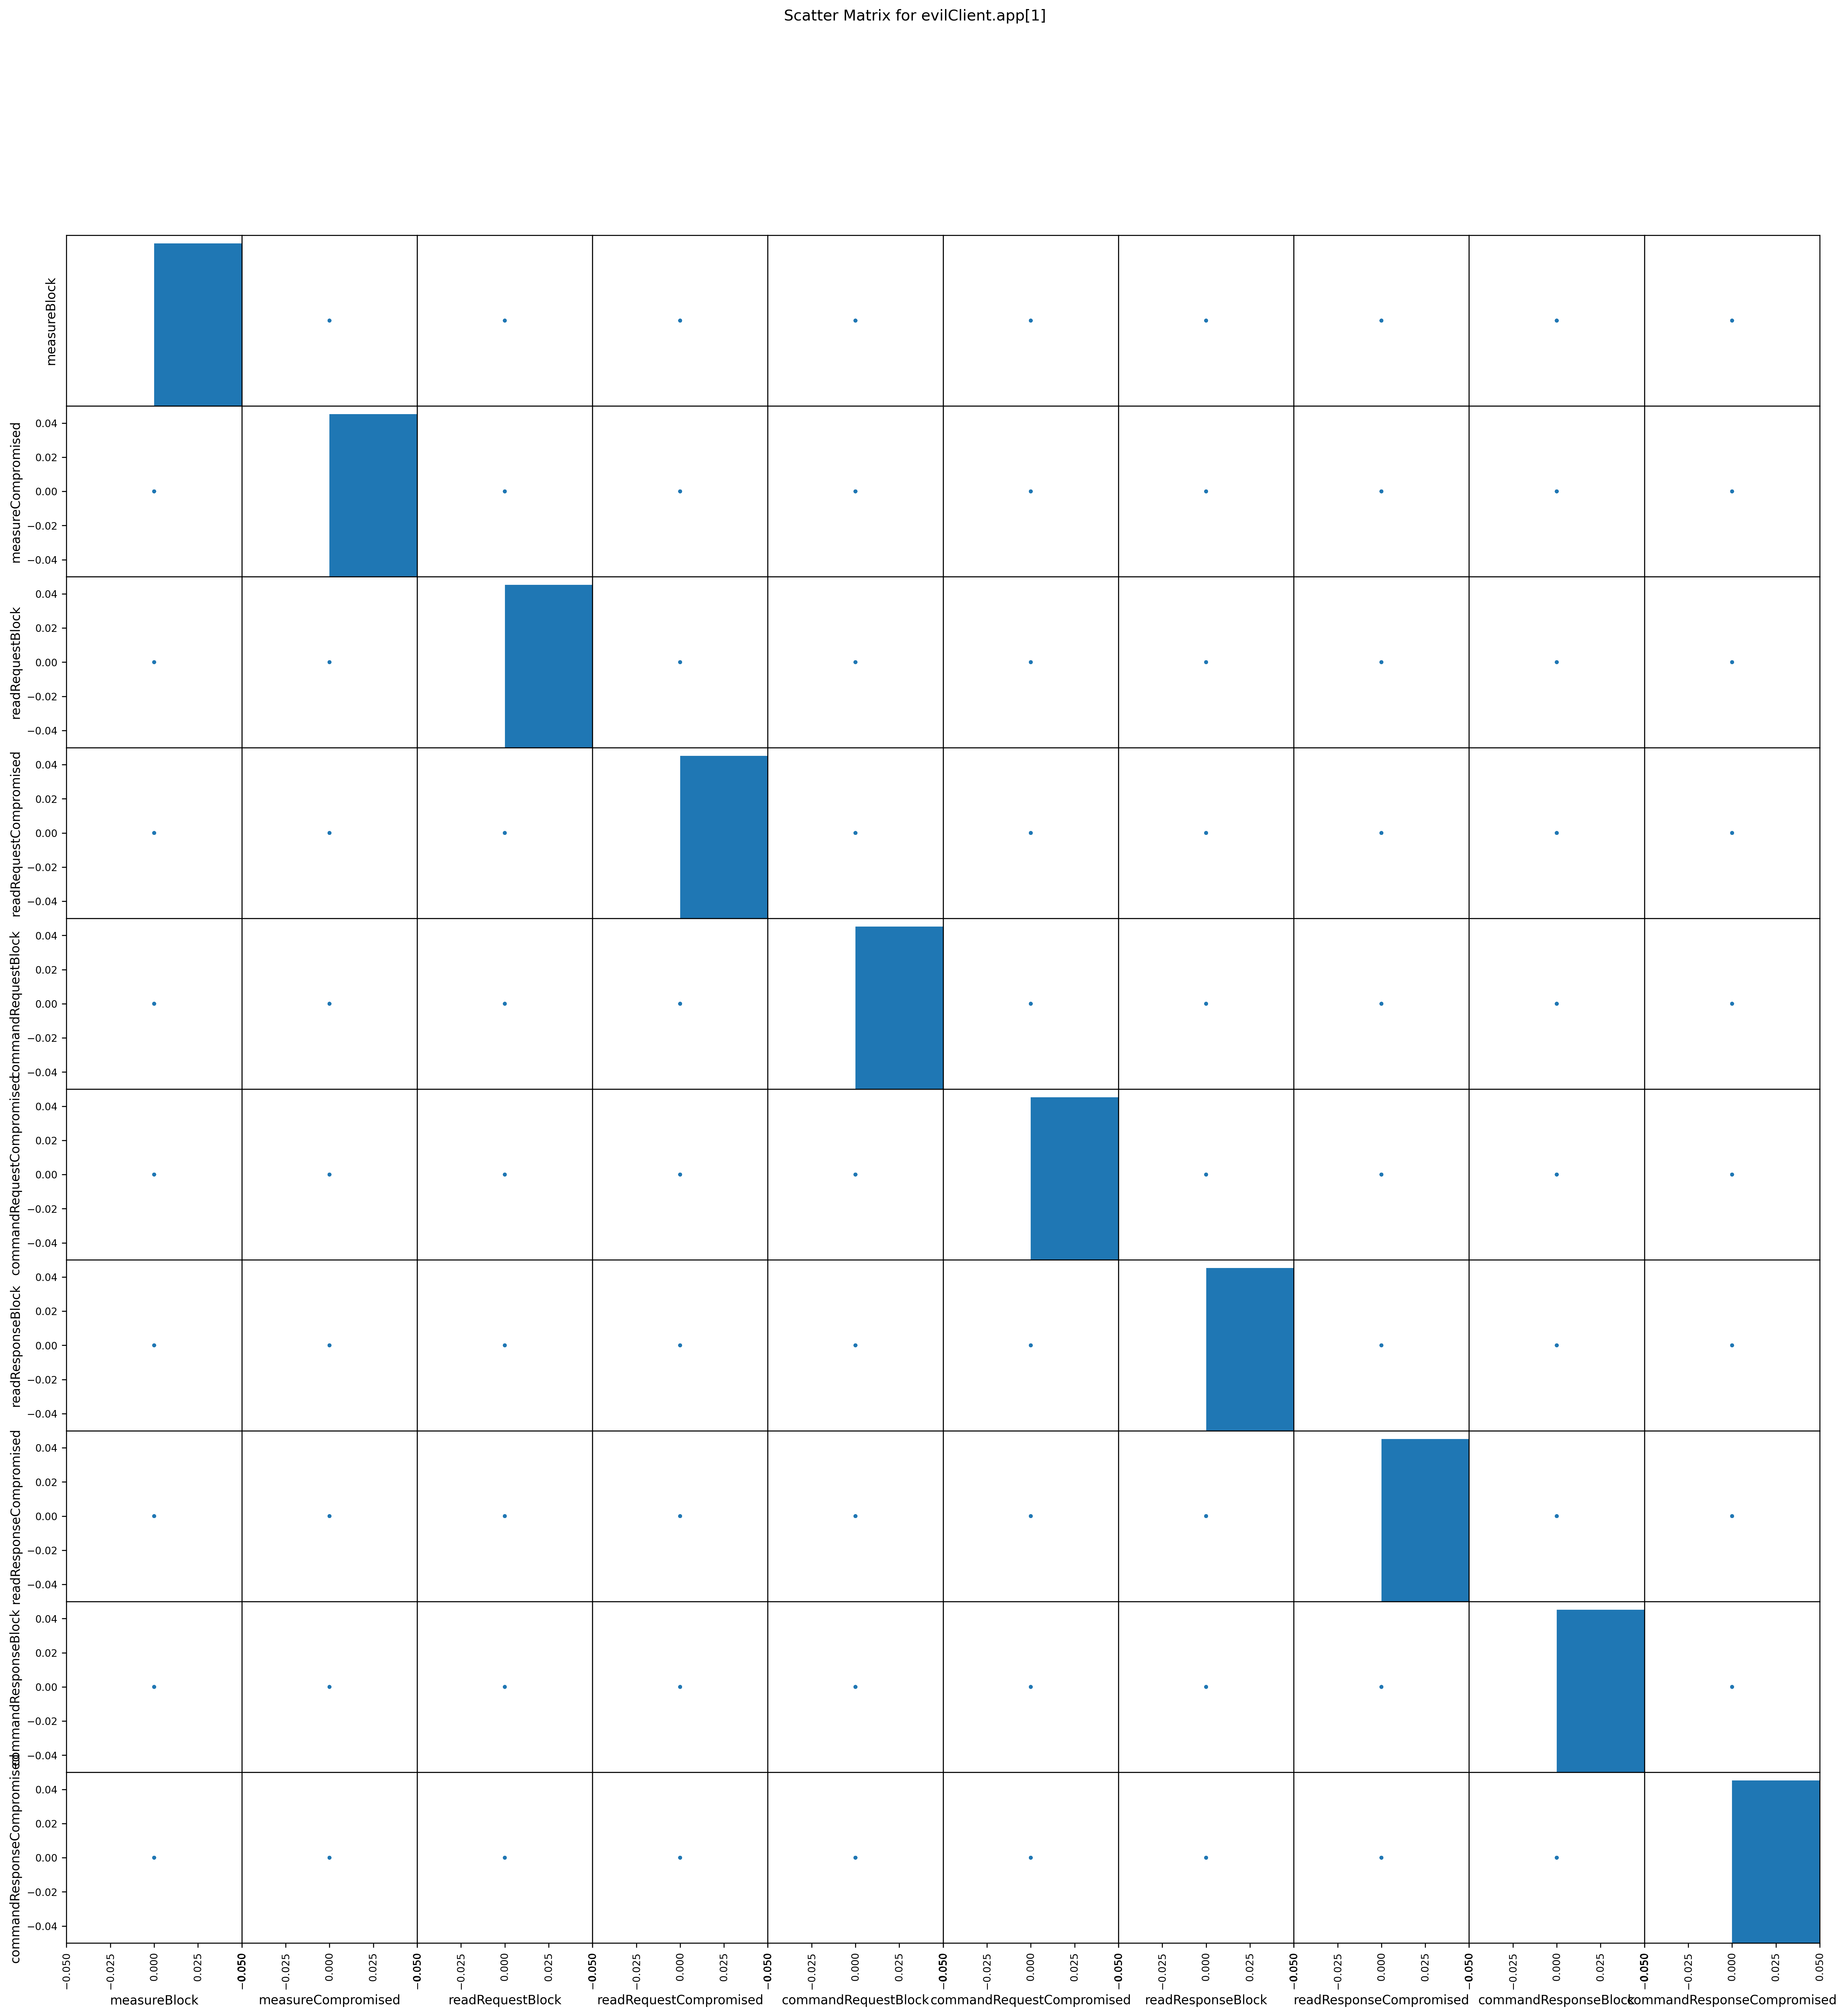

In [179]:
if not isDos:
    for j in range(numServers):
        df = evilScaDfList[j]
        print("## Data description for evilClient.app[" + str(j) + "] ##")
        print(df.describe())
        print("## Correlation Matrix ##")
        print(df.corr())
        pd.plotting.scatter_matrix(df, figsize=(25,25))
        plt.suptitle("Scatter Matrix for evilClient.app[" + str(j) + "]")

[(0, 15.0), (15.0, 30.0), (30.0, 45.0), (45.0, 60.0), (60.0, 75.0), (75.0, 90.0), (90.0, 105.0), (105.0, 120.0)]
[(0, 20.0), (20.0, 40.0), (40.0, 60.0), (60.0, 80.0), (80.0, 100.0), (100.0, 120.0)]
[]


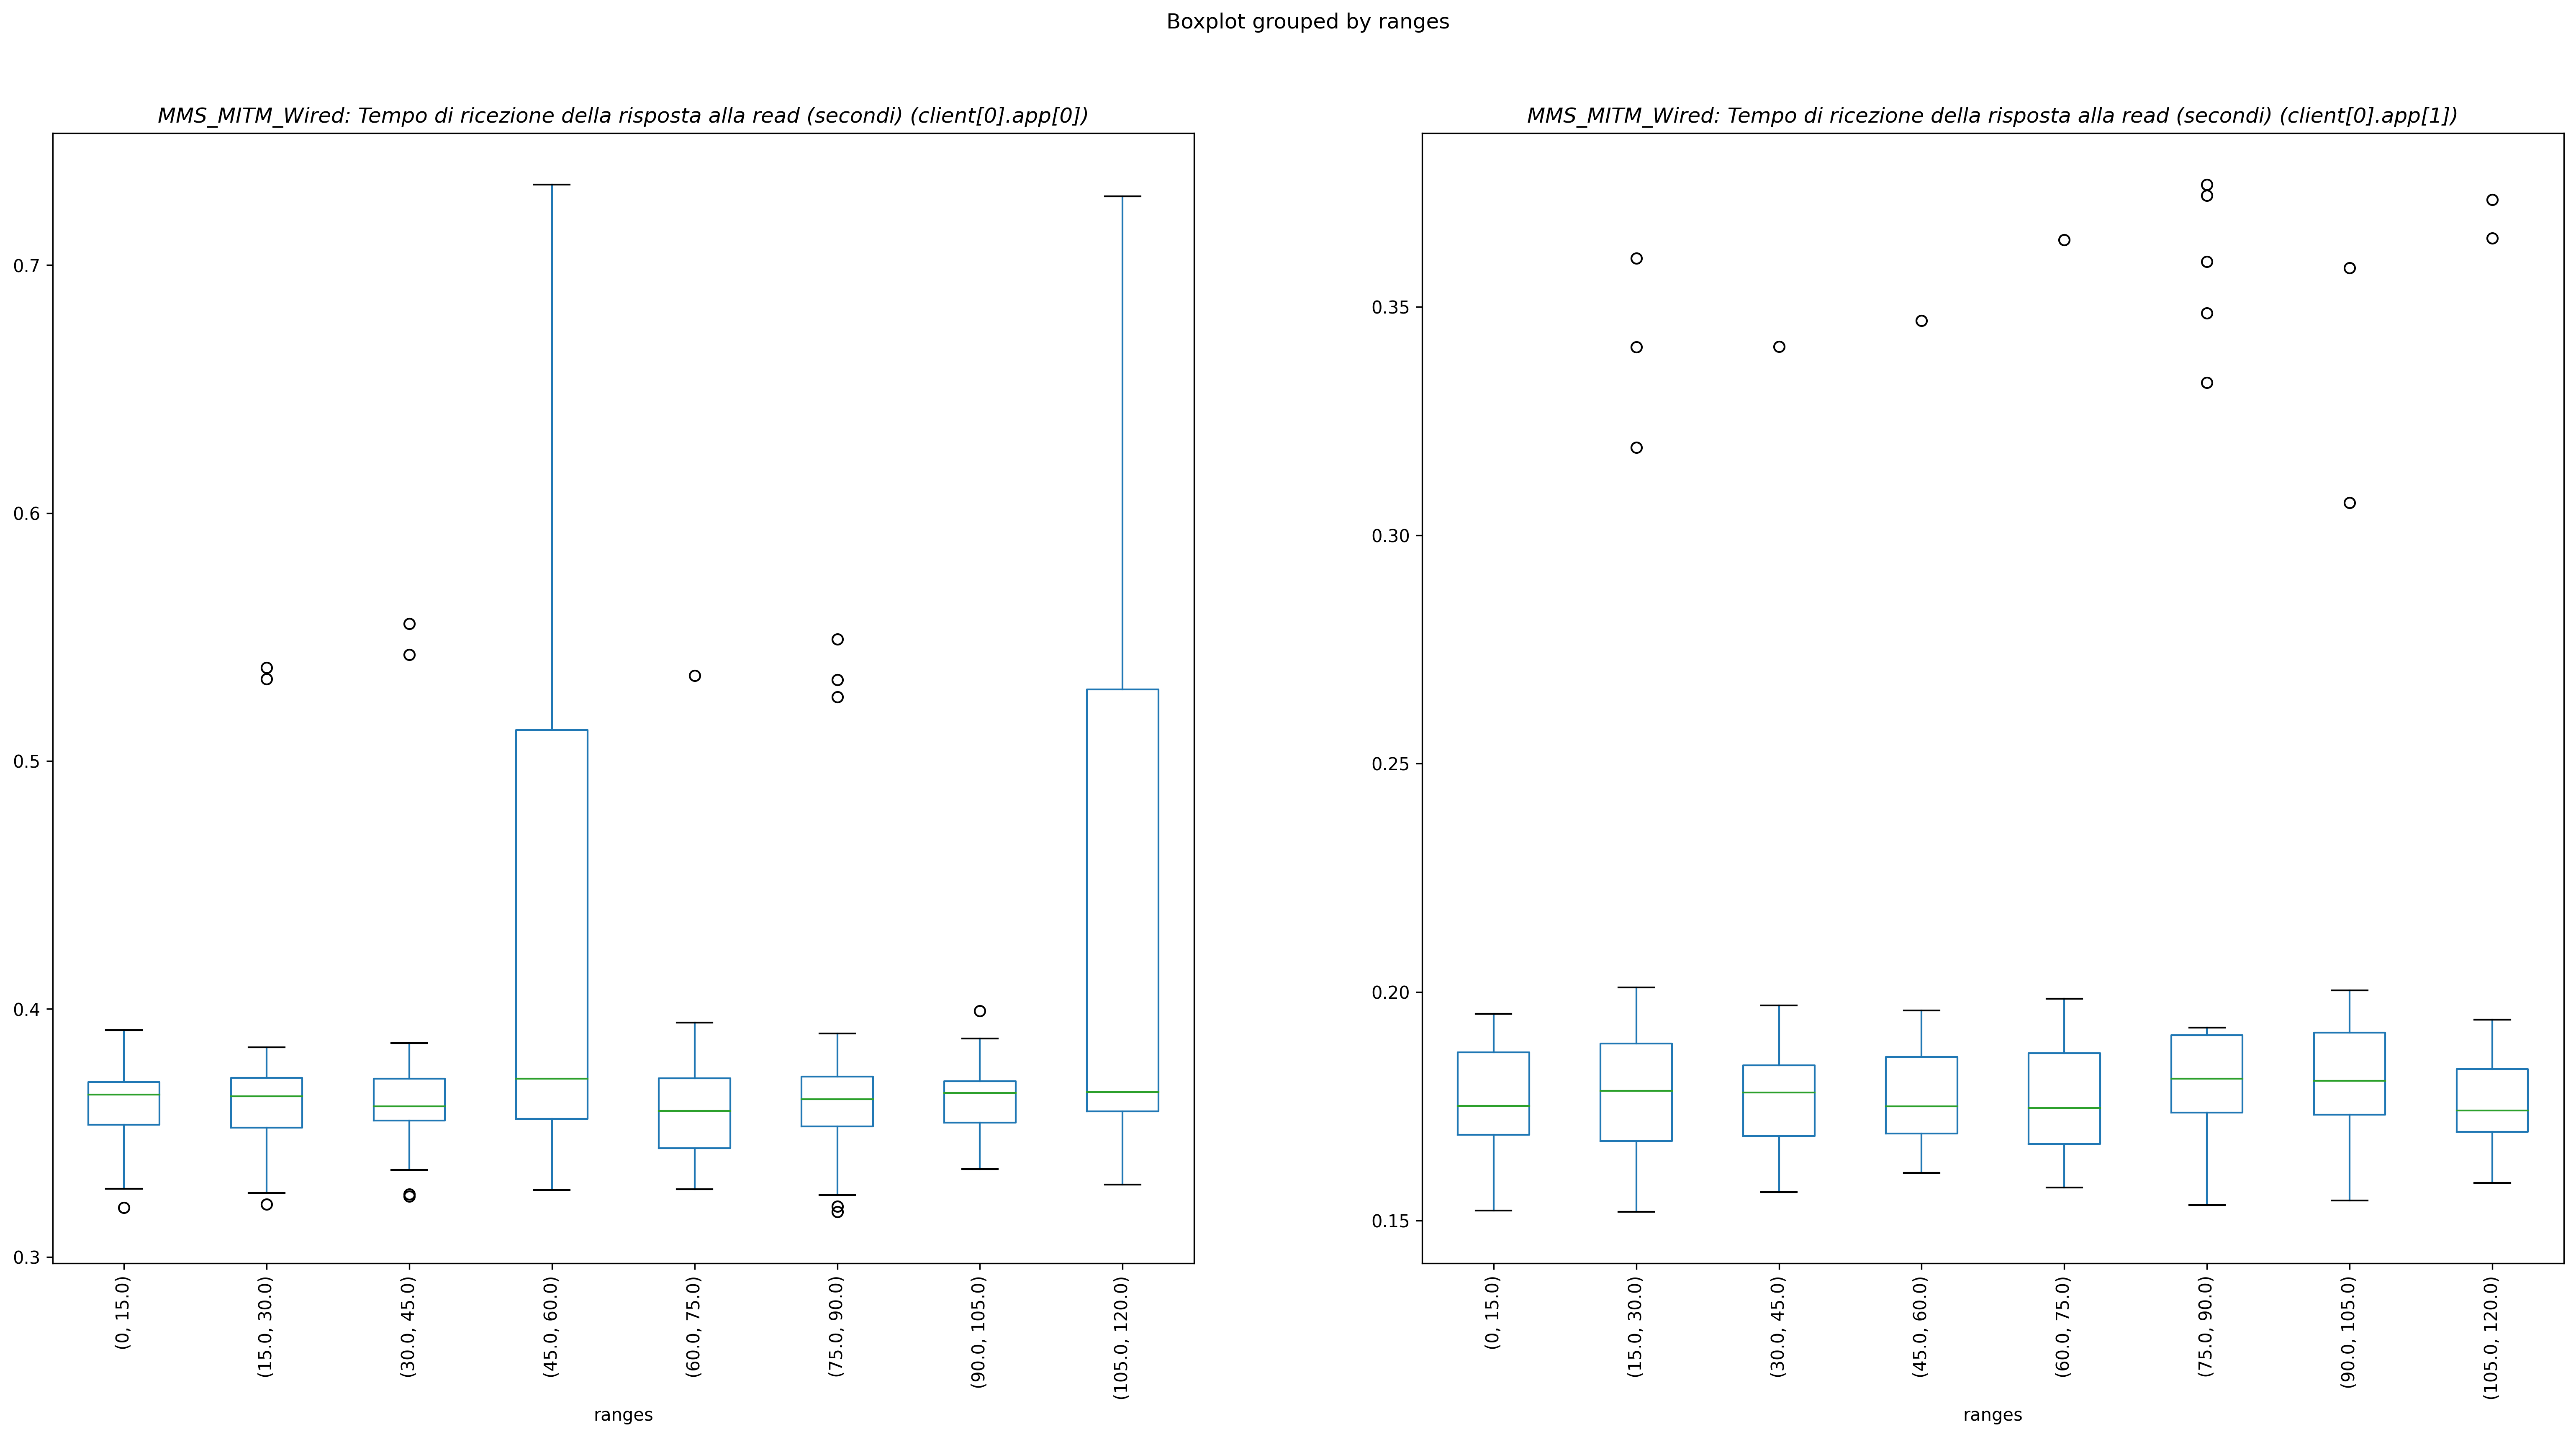

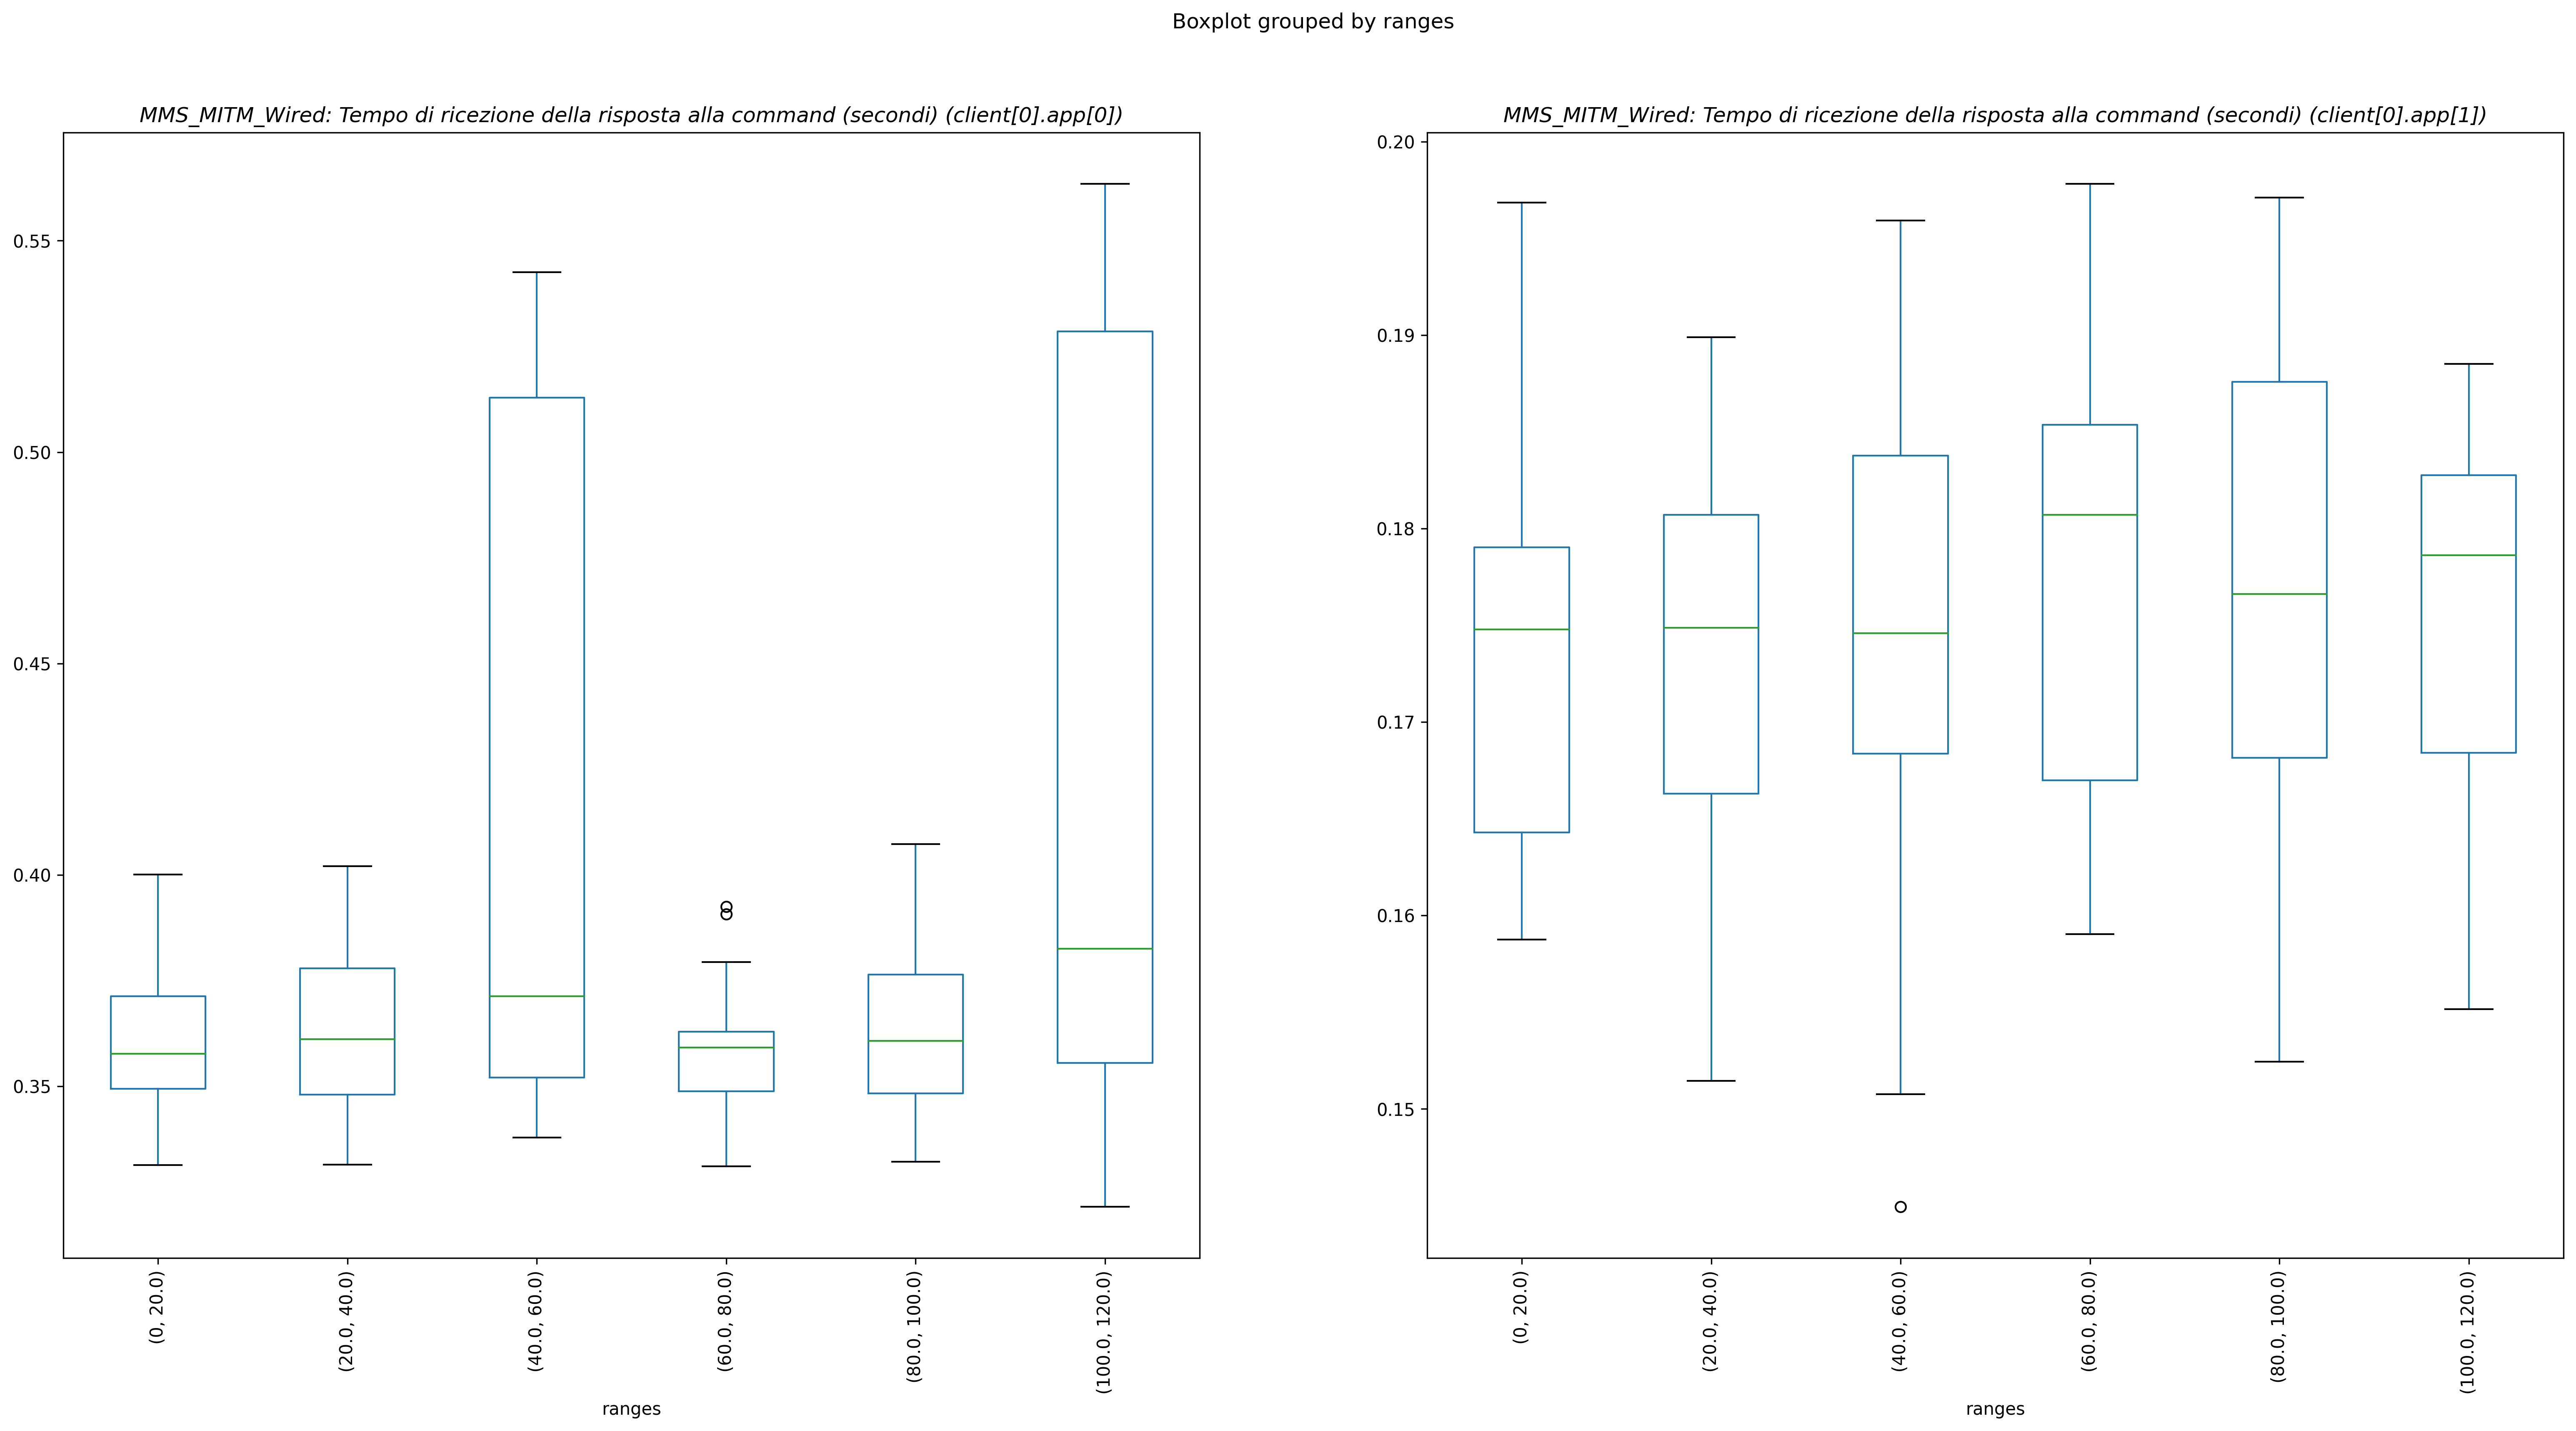

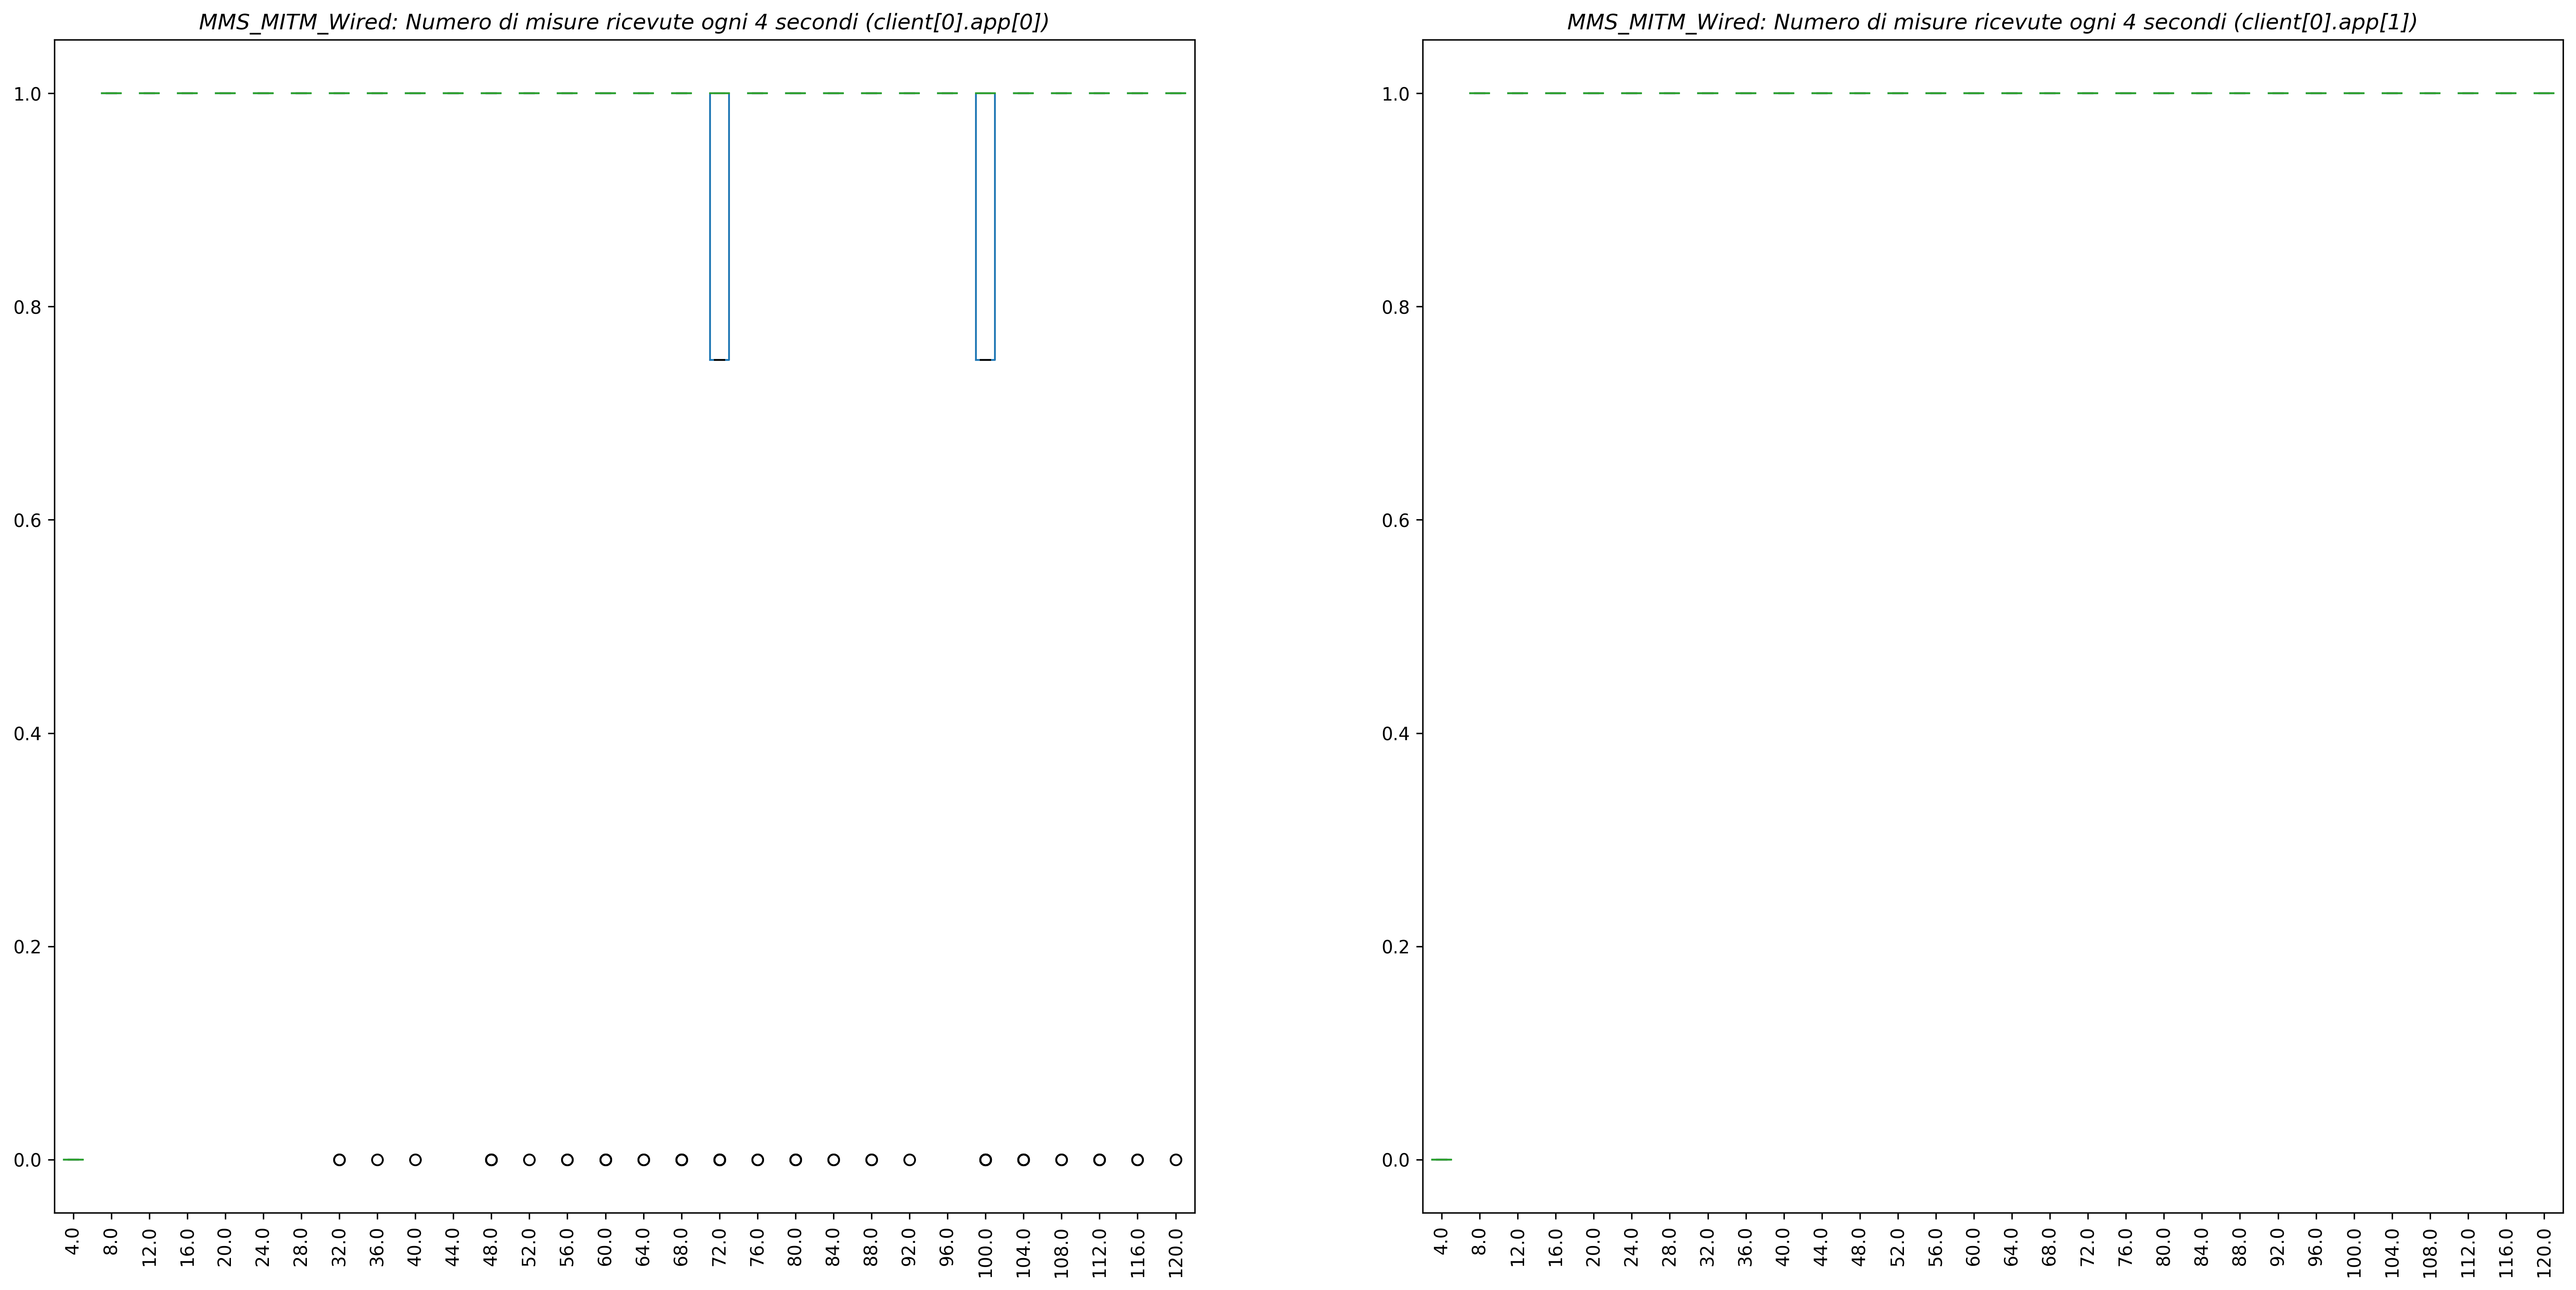

In [180]:
cliVecDfListReadTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla read (secondi)", vecMeasName="readResponseReceivedTime", numRanges = 8)
cliVecDfListCommandTime = plotBoxWiskerVec(numClients, numServers, title=simName + ": Tempo di ricezione della risposta alla command (secondi)", vecMeasName="commandResponseReceivedTime", numRanges = 6)
cliVecDfListMeasRec = plotBoxWiskerVec(numClients, numServers, title=simName + ": Numero di misure ricevute ogni 4 secondi", vecMeasName="measureReceivedAmount", numRanges = 0)

In [181]:
def plotPointsVec(numClients, numServers, title = "", cli = "client", vecMeasName = "measureReceivedAmount"):
    fig, axes = plt.subplots(nrows=numClients, ncols=numServers)
    fig.set_figheight(12*numClients)
    fig.set_figwidth(25)
    
    outVec = list()
    for i in range(numClients):
        for j in range(numServers):
            strElem = ""
            if cli == "evilClient":
                strElem = cli + ".app[" + str(j) + "]"
            else:
                strElem = cli + "[" + str(i) + "].app[" + str(j) + "]"
            
            flt = vec[vec["name"].str.contains(vecMeasName + ":" + StatType.VECTOR.value)]
            flt = flt[flt["module"].str.endswith(strElem)]
            
            colPlot = pd.DataFrame(columns=["value", "time", "color"])
            rowNum = 0
            colors = cm.rainbow(np.linspace(0, 1, len(flt["runID"])))
            for row, color in zip(flt.itertuples(), colors):
                vecValue = pd.Series(row.vecvalue)
                vecTime = pd.Series(row.vectime)
                for val, time in zip(vecValue, vecTime):    
                    colPlot.loc[rowNum] = list((val, time, color))
                    rowNum += 1
                                
            outVec.append(colPlot)
            if DEBUG:
                colPlot.to_csv("./out.csv", mode="w", header=True)
            if numClients != 1:
                axes[i][j].scatter("time", "value", data=colPlot, c=colPlot["color"])
                axes[i][j].set_title(title + " (" + strElem + ")", fontstyle='italic')
            else:
                axes[j].scatter("time", "value", data=colPlot, c=colPlot["color"])
                axes[j].set_title(title + " (" + strElem + ")", fontstyle='italic')                    
    return outVec

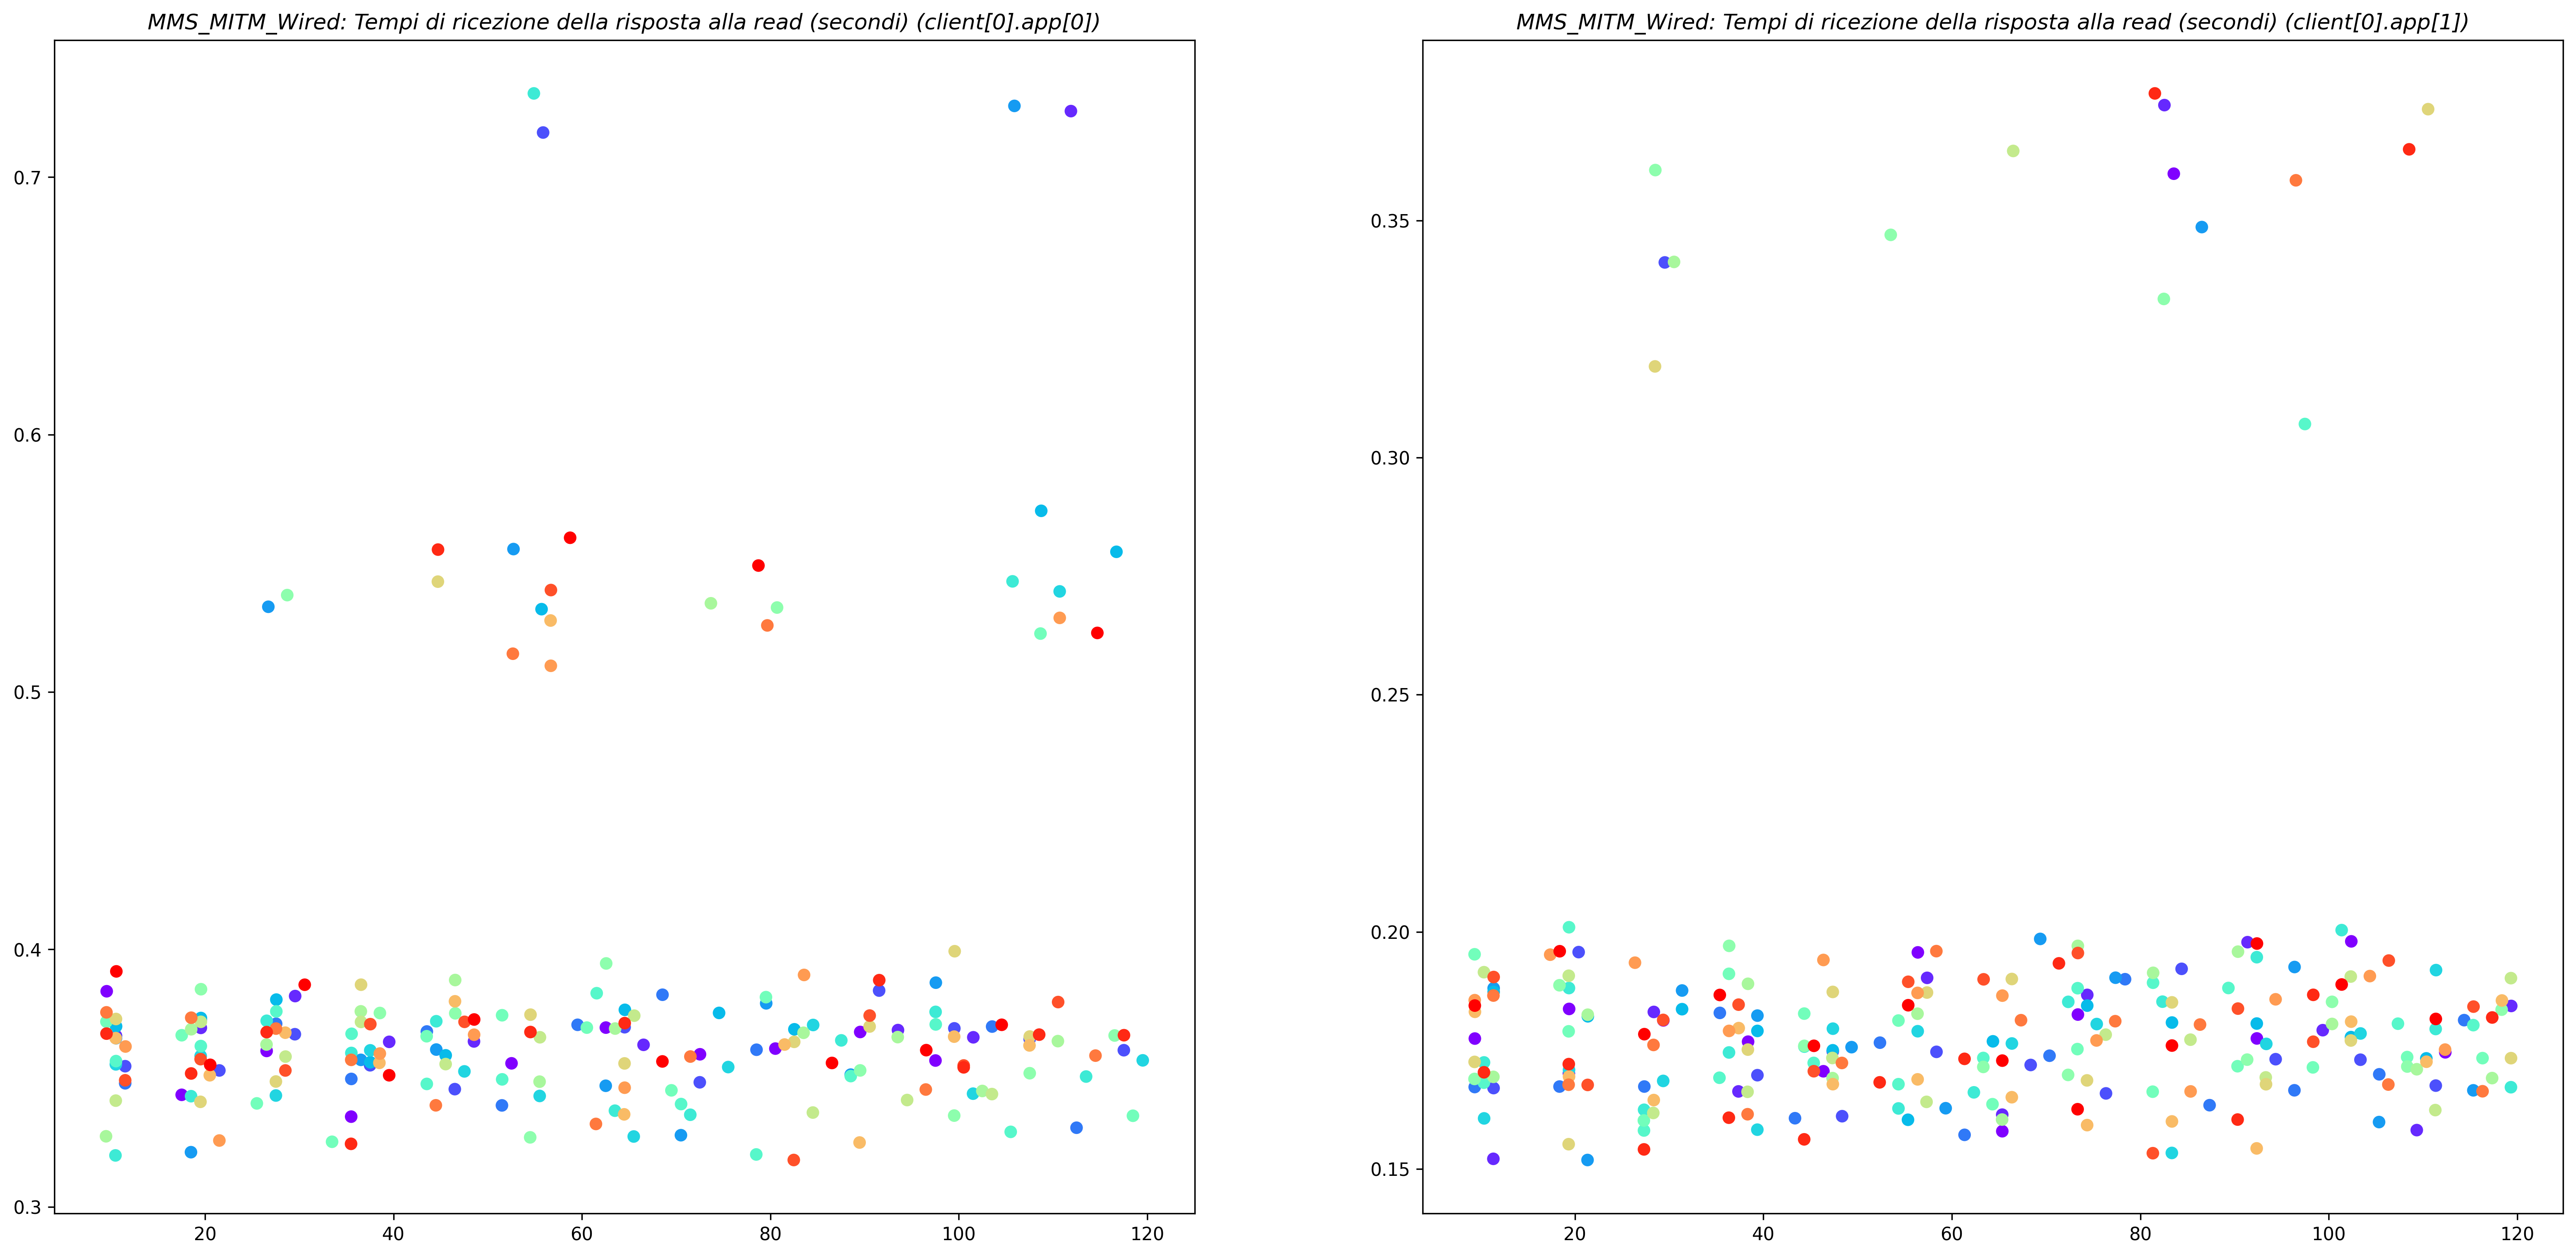

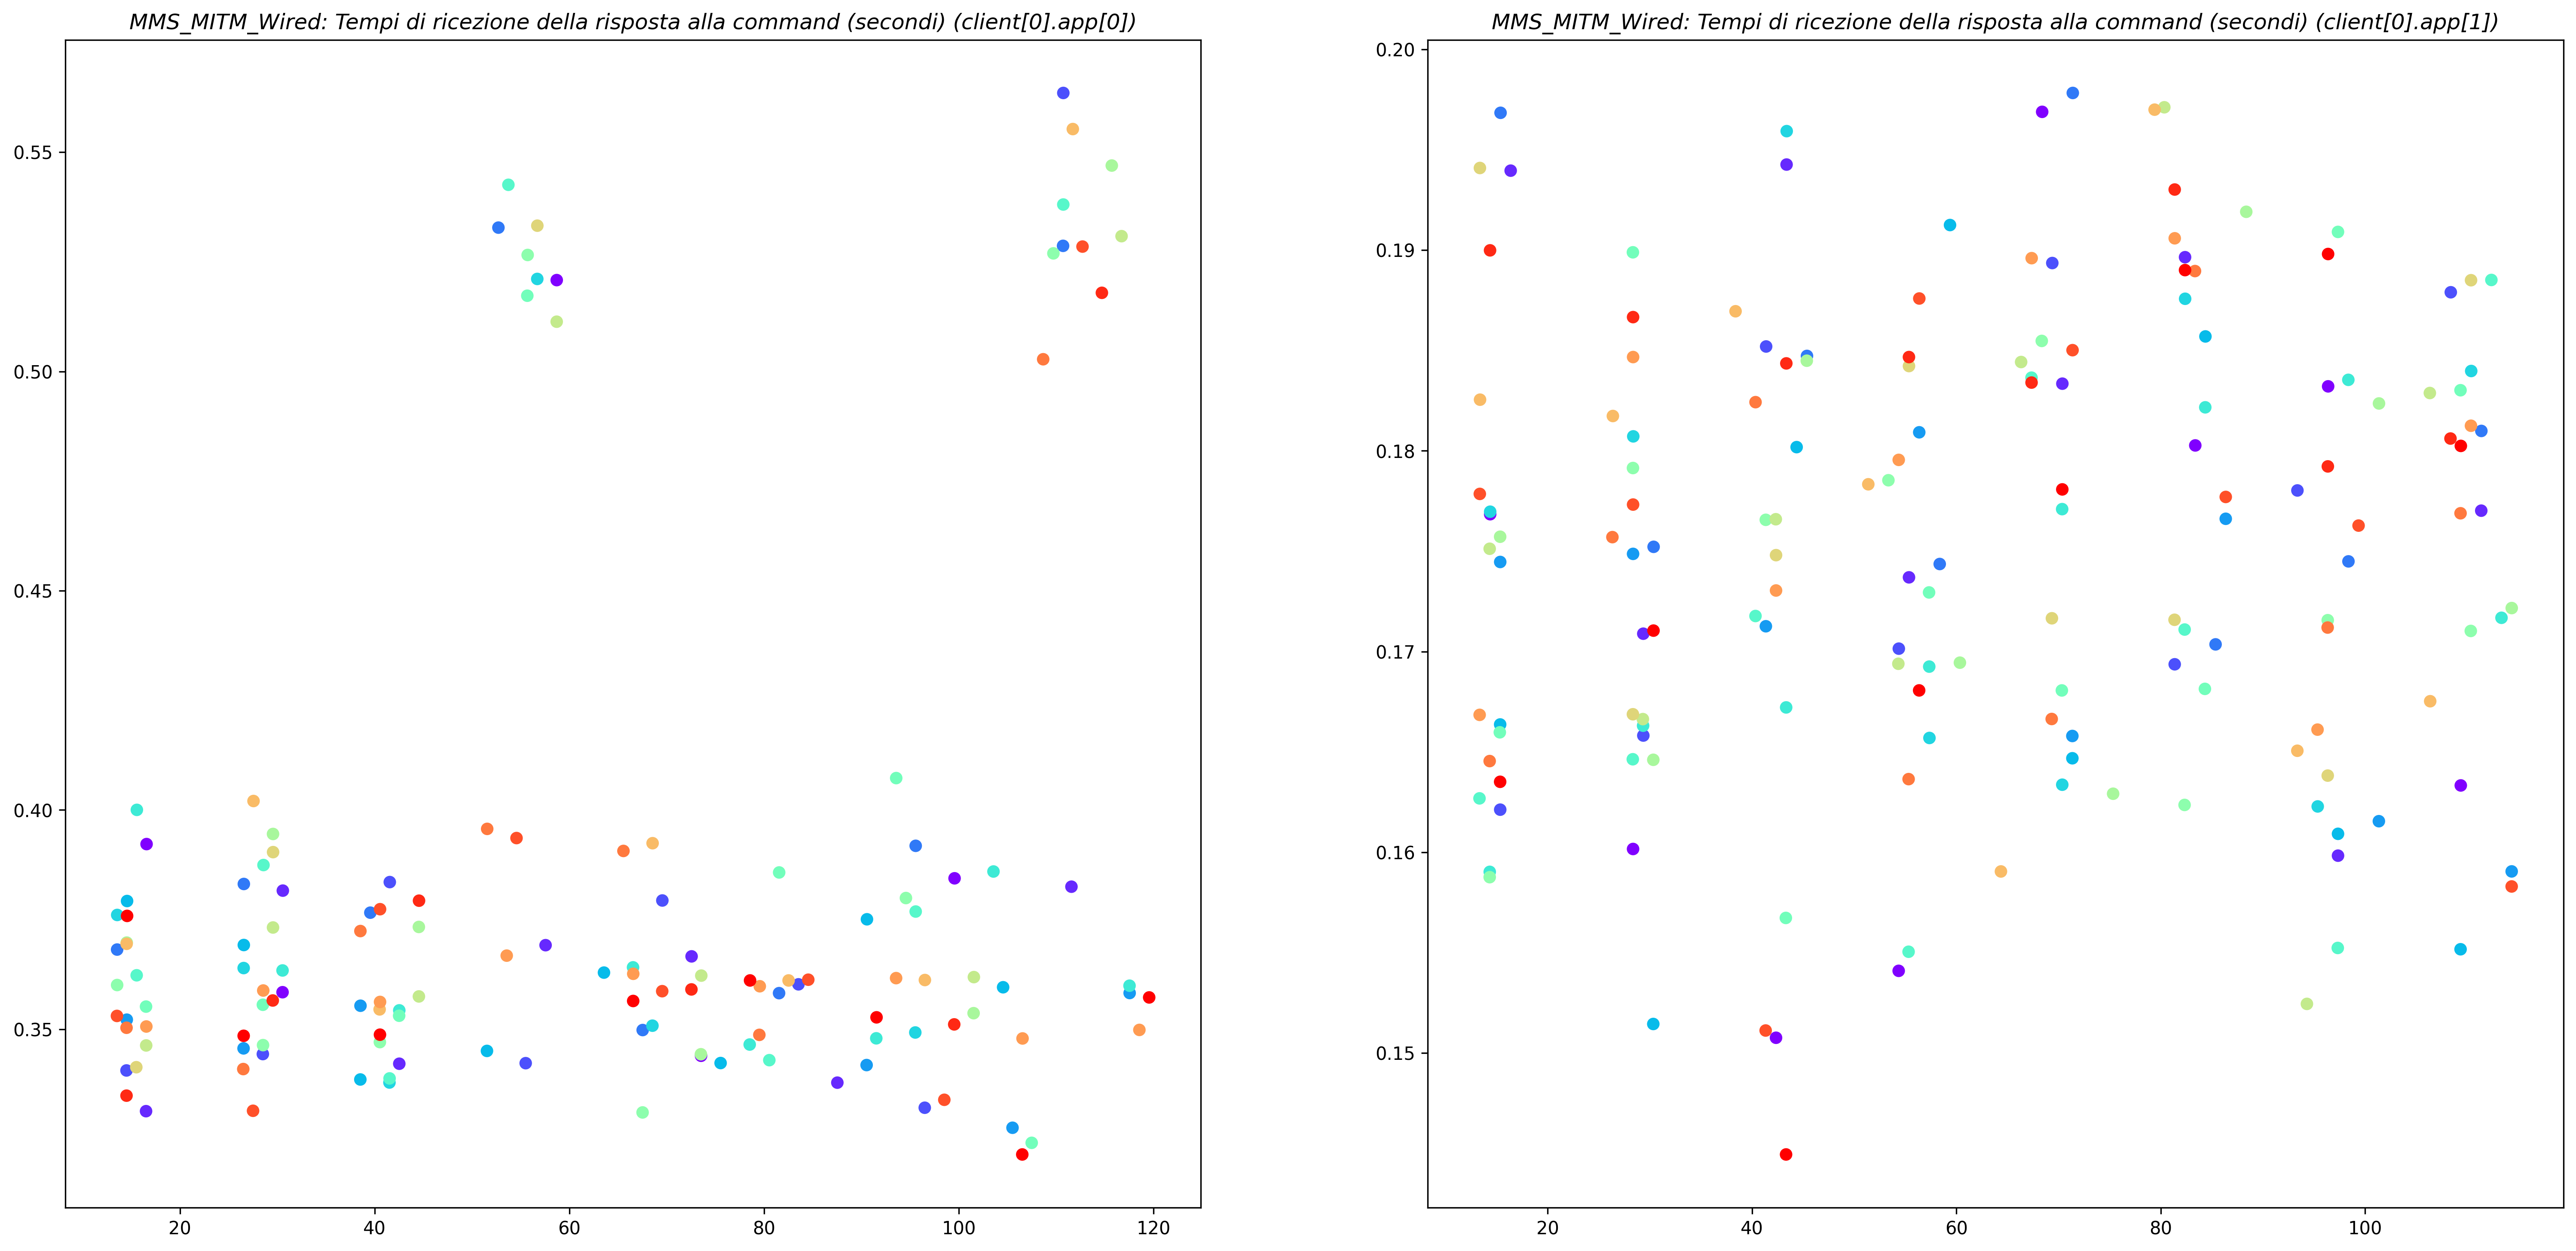

In [182]:
cliVecDfListReadTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempi di ricezione della risposta alla read (secondi)", vecMeasName="readResponseReceivedTime")
cliVecDfListCommandTimeSingles = plotPointsVec(numClients, numServers, title=simName + ": Tempi di ricezione della risposta alla command (secondi)", vecMeasName="commandResponseReceivedTime")

In [220]:
def confidenceInterval(data, confidence = 0.95):
    for (colName, colData) in data.iteritems():
        a = 1.0 * np.array(colData.values)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * np.abs(scipy.stats.t.ppf((1-confidence)/2.0, n-1))
        relAcc = (h / m) * 100
        
        # m, m-h, m+h
        print("## Stat: " + colName)
        print("Average: " + str(round(m, 2)))
        print("Quantile: +-" + str(round(h, 2)))
        print("Relative accuracy: " + str(round(relAcc, 2)) + " %")
        if DEBUG:   
            interval = scipy.stats.t.interval(confidence, df=n-1, loc=m, scale=se)
            print("Debug interval: " + str((interval[1] - interval[0])/2))
         

Confidence interval for the different statistics

In [222]:
conf = 0.95
for i in range(numClients):
    for j in range(numServers):
        print("\n** " + simName + ": Confidence intervals for client[" + str(i) + "].app[" + str(j) + "] at " + str(conf*100) + "%  **")
        confidenceInterval(cliScaDfList[(i+1)*j], conf)


** MMS_MITM_Wired: Confidence intervals for client[0].app[0] at 95.0%  **
## Stat: readSent
Average: 12.75
Quantile: +-0.21
Relative accuracy: 1.63 %
Debug interval: 0.20792085631344115
## Stat: commandSent
Average: 8.3
Quantile: +-0.22
Relative accuracy: 2.65 %
Debug interval: 0.22004275127558337
## Stat: readResponse
Average: 11.0
Quantile: +-0.53
Relative accuracy: 4.78 %
Debug interval: 0.5260027832024594
## Stat: commandResponse
Average: 6.9
Quantile: +-0.62
Relative accuracy: 9.05 %
Debug interval: 0.6242244442860532
## Stat: readResponseTimeout
Average: 1.4
Quantile: +-0.49
Relative accuracy: 34.98 %
Debug interval: 0.4896819418886458
## Stat: commandResponseTimeout
Average: 1.25
Quantile: +-0.57
Relative accuracy: 45.25 %
Debug interval: 0.565605879059657

** MMS_MITM_Wired: Confidence intervals for client[0].app[1] at 95.0%  **
## Stat: readSent
Average: 12.6
Quantile: +-0.24
Relative accuracy: 1.87 %
Debug interval: 0.23523559591895626
## Stat: commandSent
Average: 8.0
Quant

/tmp/ipykernel_19056/2305554413.py:7: RuntimeWarning: invalid value encountered in double_scalars
  relAcc = (h / m) * 100


In [185]:
for j in range(numServers):
    print("\n** " + simName + ": Confidence intervals for evilClient.app[" + str(j) + "] at " + str(conf*100) + "%  **")
    confidenceInterval(evilScaDfList[j], conf)


** MMS_MITM_Wired: Confidence intervals for evilClient.app[0] at 98.0%  **
## Stat: measureBlock
Average: 2.6
Quantile: +--0.01
Relative accuracy: -0.35 %
## Stat: measureCompromised
Average: 4.05
Quantile: +--0.01
Relative accuracy: -0.24 %
## Stat: readRequestBlock
Average: 1.05
Quantile: +--0.01
Relative accuracy: -0.48 %
## Stat: readRequestCompromised
Average: 4.35
Quantile: +--0.01
Relative accuracy: -0.18 %
## Stat: commandRequestBlock
Average: 0.6
Quantile: +--0.0
Relative accuracy: -0.78 %
## Stat: commandRequestCompromised
Average: 3.05
Quantile: +--0.01
Relative accuracy: -0.2 %
## Stat: readResponseBlock
Average: 0.7
Quantile: +--0.0
Relative accuracy: -0.65 %
## Stat: readResponseCompromised
Average: 3.1
Quantile: +--0.01
Relative accuracy: -0.28 %
## Stat: commandResponseBlock
Average: 0.8
Quantile: +--0.0
Relative accuracy: -0.49 %
## Stat: commandResponseCompromised
Average: 1.7
Quantile: +--0.01
Relative accuracy: -0.34 %

** MMS_MITM_Wired: Confidence intervals for e

/tmp/ipykernel_19056/2234314489.py:7: RuntimeWarning: invalid value encountered in double_scalars
  relAcc = (h / m) * 100
